<a href="https://colab.research.google.com/github/abiantorres/deepfake-detection/blob/master/deepfake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

## Enviroment setup

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

def gpu_setup():
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  if gpu.memoryUtil > 0:
    !kill -9 -1
  def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

gpu_setup()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 150.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
from tensorflow.keras.utils import HDF5Matrix

In [0]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
from sklearn import preprocessing
import os
import random
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, average_precision_score
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer, Normalizer
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib 
import h5py
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
!sudo pip install face_recognition
import face_recognition

     |████████████████████████████████| 100.2MB 1.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
 !sudo pip install face_alignment
import face_alignment

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
BLOCK_A_FEATURES_SHAPE = (80, 299, 299, 3)
BLOCK_B_FEATURES_SHAPE = (80, 18)
XCEPTION_SIZE = 299
N_FEATURES = 18
N_FRAMES = 80
FRAMES_SHIFT = 3
FAKE_LABEL = 1.
REAL_LABEL = 0.

In [0]:
DATASET_PATH = os.path.dirname('gdrive/My Drive/TFM/DATASET/')
TRAIN_FOLDERS = {'Deepfakes': (os.path.join(DATASET_PATH, 'Deepfakes/train/'), FAKE_LABEL), 
                 'Face2Face': (os.path.join(DATASET_PATH, 'Face2Face/train/'), FAKE_LABEL),
                 'FaceSwap': (os.path.join(DATASET_PATH, 'FaceSwap/train/'), FAKE_LABEL),
                 'Reals': (os.path.join(DATASET_PATH, 'Reals/train/'), REAL_LABEL)}
VAL_FOLDERS = {'Deepfakes': (os.path.join(DATASET_PATH, 'Deepfakes/validation/'), FAKE_LABEL), 
                 'Face2Face': (os.path.join(DATASET_PATH, 'Face2Face/validation/'), FAKE_LABEL),
                 'FaceSwap': (os.path.join(DATASET_PATH, 'FaceSwap/validation/'), FAKE_LABEL),
                 'Reals': (os.path.join(DATASET_PATH, 'Reals/validation/'), REAL_LABEL)}
TEST_FOLDERS = {'Deepfakes': (os.path.join(DATASET_PATH, 'Deepfakes/test/'), FAKE_LABEL), 
                 'Face2Face': (os.path.join(DATASET_PATH, 'Face2Face/test/'), FAKE_LABEL),
                 'FaceSwap': (os.path.join(DATASET_PATH, 'FaceSwap/test/'), FAKE_LABEL),
                 'Reals': (os.path.join(DATASET_PATH, 'Reals/test/'), REAL_LABEL)}
TRAIN_FEATURES = {'X': os.path.join(DATASET_PATH, 'landmarks_features/X.npy'), 
                 'y': os.path.join(DATASET_PATH, 'landmarks_features/y.npy'),
                 'method': os.path.join(DATASET_PATH, 'landmarks_features/method.npy'),
                 'path': os.path.join(DATASET_PATH, 'landmarks_features/path.npy')}
TEST_FEATURES = {'X_t': os.path.join(DATASET_PATH, 'landmarks_features/X_t.npy'), 
                 'y_t': os.path.join(DATASET_PATH, 'landmarks_features/y_t.npy'),
                 'method_t': os.path.join(DATASET_PATH, 'landmarks_features/method_t.npy'),
                 'path_t': os.path.join(DATASET_PATH, 'landmarks_features/path_t.npy')}
VALIDATION_FEATURES = {'X_v': os.path.join(DATASET_PATH, 'landmarks_features/X_v.npy'), 
                 'y_v': os.path.join(DATASET_PATH, 'landmarks_features/y_v.npy'),
                 'method_v': os.path.join(DATASET_PATH, 'landmarks_features/method_v.npy'),
                 'path_v': os.path.join(DATASET_PATH, 'landmarks_features/path_v.npy')}
TRAIN_NN_FEATURES = {'X': os.path.join(DATASET_PATH, 'landmarks_features/X_nn.npy'), 
                 'y': os.path.join(DATASET_PATH, 'landmarks_features/y_nn.npy'),
                 'method': os.path.join(DATASET_PATH, 'landmarks_features/method_nn.npy'),
                 'path': os.path.join(DATASET_PATH, 'landmarks_features/path_nn.npy')}
VALIDATION_NN_FEATURES = {'X_v': os.path.join(DATASET_PATH, 'landmarks_features/X_val_nn.npy'), 
                 'y_v': os.path.join(DATASET_PATH, 'landmarks_features/y_val_nn.npy'),
                 'method_v': os.path.join(DATASET_PATH, 'landmarks_features/method_val_nn.npy'),
                 'path_v': os.path.join(DATASET_PATH, 'landmarks_features/path_val_nn.npy')}
TEST_NN_FEATURES = {'X_t': os.path.join(DATASET_PATH, 'landmarks_features/X_test_nn.npy'), 
                 'y_t': os.path.join(DATASET_PATH, 'landmarks_features/y_test_nn.npy'),
                 'method_t': os.path.join(DATASET_PATH, 'landmarks_features/method_test_nn.npy'),
                 'path_t': os.path.join(DATASET_PATH, 'landmarks_features/path_test_nn.npy')}
SCALER = os.path.join(DATASET_PATH, 'landmarks_features/scaler.save')
HISTORY_LOSS = os.path.join(DATASET_PATH, 'landmarks_features/history_loss.npy')
HISTORY_ACC = os.path.join(DATASET_PATH, 'landmarks_features/history_acc.npy')
MODEL = os.path.join(DATASET_PATH, 'landmarks_features/model.h5')
TUNING_MODEL = os.path.join(DATASET_PATH, 'landmarks_features/tuning_model.h5')
MODEL_B = os.path.join(DATASET_PATH, 'landmarks_features/model_b.h5')
MODEL_B_TUNING = os.path.join(DATASET_PATH, 'landmarks_features/model_b_tuning.h5')
MODEL_B_BEST = os.path.join(DATASET_PATH, 'landmarks_features/model_best.h5')

TF_RECORDS = {'train': os.path.join(DATASET_PATH, 'tf_datasets/train/train.tfrecords'), 
              'test': os.path.join(DATASET_PATH, 'tf_datasets/test/test.tfrecords'),
              'val': os.path.join(DATASET_PATH, 'tf_datasets/val/val.tfrecords')}


In [0]:
TRAIN_H5PY_FILE = os.path.join(DATASET_PATH, 'CROPPED_FACES/train/train_cropped_faces.hdf5')
VALIDATION_H5PY_FILE = os.path.join(DATASET_PATH, 'CROPPED_FACES/validation/validation_cropped_faces.hdf5')
TEST_H5PY_FILE = os.path.join(DATASET_PATH, 'CROPPED_FACES/test/test_cropped_faces.hdf5')

In [0]:
TRAIN_H5PY_FILE_1 = os.path.join(DATASET_PATH, 'CROPPED_FACES/train/train_cropped_faces_1.hdf5')
TRAIN_H5PY_FILE_2 = os.path.join(DATASET_PATH, 'CROPPED_FACES/train/train_cropped_faces_2.hdf5')
TRAIN_H5PY_FILE_3 = os.path.join(DATASET_PATH, 'CROPPED_FACES/train/train_cropped_faces_3.hdf5')
TRAIN_H5PY_FILE_4 = os.path.join(DATASET_PATH, 'CROPPED_FACES/train/train_cropped_faces_4.hdf5')
TRAIN_H5PY_FILE_5 = os.path.join(DATASET_PATH, 'CROPPED_FACES/train/train_cropped_faces_5.hdf5')

TRAIN_TF_RECORDS_1 = os.path.join(DATASET_PATH, 'tf_datasets/train/train_1.tfrecords')
TRAIN_TF_RECORDS_2 = os.path.join(DATASET_PATH, 'tf_datasets/train/train_2.tfrecords')
TRAIN_TF_RECORDS_3 = os.path.join(DATASET_PATH, 'tf_datasets/train/train_3.tfrecords')
TRAIN_TF_RECORDS_4 = os.path.join(DATASET_PATH, 'tf_datasets/train/train_4.tfrecords')
TRAIN_TF_RECORDS_5 = os.path.join(DATASET_PATH, 'tf_datasets/train/train_5.tfrecords')



---

## Feature extraction

In [0]:
fa3d = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, face_detector='sfd', flip_input=False, device='cuda')

In [0]:
"""https://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/"""

In [0]:
XCEPTION_SIZE = 299

In [0]:
def get_face_region(image,  required_size=(XCEPTION_SIZE, XCEPTION_SIZE)):
  face_bounding_boxes = face_recognition.face_locations(image, number_of_times_to_upsample = 1, model="cnn")
  if face_bounding_boxes is None or len(face_bounding_boxes) < 1:
    return False, None
  else:
    top, right, bottom, left = face_bounding_boxes[0]
    return True, cv2.resize(image[top:bottom, left:right], dsize=required_size)

![Landmarks numeration](https://cdn-images-1.medium.com/max/1600/1*96UT-D8uSXjlnyvs9DZTog.png)

In [0]:
def get_3d_landmarks(im):
  landmarks3d = fa3d.get_landmarks(im)
  if(landmarks3d is None or len(landmarks3d) == 0 or len(landmarks3d) > 1):
    return False, None
  return True, landmarks3d[0]

In [0]:
def get_relevant_landmarks(landmarks3d):
  
  relevant_landmarks3d = {}
  
  relevant_landmarks3d['chin'] = landmarks3d[8]
  relevant_landmarks3d['nose_tip'] = landmarks3d[33]
  relevant_landmarks3d['right_eye_right_corner'] = landmarks3d[45]
  relevant_landmarks3d['left_eye_left_corner'] = landmarks3d[36]
  relevant_landmarks3d['right_mouth_corner'] = landmarks3d[54]
  relevant_landmarks3d['left_mouth_corner'] = landmarks3d[48]
  
  return relevant_landmarks3d

![Landmarks numeration](https://www.pyimagesearch.com/wp-content/uploads/2017/04/blink_detection_plot.jpg)

In [0]:
def compute_eyes_blinking_ratio(landmarks3d):
  left_eye_ratio = (dist.euclidean(landmarks3d[37], landmarks3d[41]) 
                    + dist.euclidean(landmarks3d[38], landmarks3d[40])) / (2 * dist.euclidean(landmarks3d[36], landmarks3d[39]))
  right_eye_ratio = (dist.euclidean(landmarks3d[43], landmarks3d[47]) 
                     + dist.euclidean(landmarks3d[44], landmarks3d[46])) / (2 * dist.euclidean(landmarks3d[42], landmarks3d[45]))
  return left_eye_ratio, right_eye_ratio

In [0]:
def compute_mouth_opening_ratio(landmarks3d):
  return (dist.euclidean(landmarks3d[61], landmarks3d[67]) 
          + dist.euclidean(landmarks3d[62], landmarks3d[66]) 
          + dist.euclidean(landmarks3d[63], landmarks3d[65])) / (2 * dist.euclidean(landmarks3d[60], landmarks3d[64]))

In [0]:
def compute_structure_distances(landmarks3d):
  return [dist.euclidean(landmarks3d[27], landmarks3d[33]), 
         dist.euclidean(landmarks3d[33], landmarks3d[51]),
         dist.euclidean(landmarks3d[57], landmarks3d[8]),
         dist.euclidean(landmarks3d[1], landmarks3d[33]),
         dist.euclidean(landmarks3d[33], landmarks3d[15]),
         dist.euclidean(landmarks3d[37], landmarks3d[19]),
         dist.euclidean(landmarks3d[44], landmarks3d[24]),
         dist.euclidean(landmarks3d[1], landmarks3d[36]),
         dist.euclidean(landmarks3d[45], landmarks3d[15])]

In [0]:
def get_head_pose_vector(relevant_landmarks3d, size):
  # 3D model points.
  model_points = np.array([relevant_landmarks3d['nose_tip'], 
                           relevant_landmarks3d['chin'],
                           relevant_landmarks3d['left_eye_left_corner'], 
                           relevant_landmarks3d['right_eye_right_corner'], 
                           relevant_landmarks3d['left_mouth_corner'], 
                           relevant_landmarks3d['right_mouth_corner']], dtype=np.float32)
  # Camera internals
  focal_length = size[1]
  center = (size[1]/2, size[0]/2)
  camera_matrix = np.array([[focal_length, 0, center[0]],
                           [0, focal_length, center[1]],
                           [0, 0, 1]], dtype=np.float32)
  dist_coeffs = np.zeros((4,1), dtype=np.float32) # Assuming no lens distortion
  
  identity_camera_matriz = np.identity(3, dtype = np.float32) 

  # 2D model points.
  image_points = np.array([project_3d_to_2d(relevant_landmarks3d['nose_tip'], identity_camera_matriz, dist_coeffs), 
                           project_3d_to_2d(relevant_landmarks3d['chin'], identity_camera_matriz, dist_coeffs),
                           project_3d_to_2d(relevant_landmarks3d['left_eye_left_corner'], identity_camera_matriz, dist_coeffs), 
                           project_3d_to_2d(relevant_landmarks3d['right_eye_right_corner'], identity_camera_matriz, dist_coeffs), 
                           project_3d_to_2d(relevant_landmarks3d['left_mouth_corner'], identity_camera_matriz, dist_coeffs), 
                           project_3d_to_2d(relevant_landmarks3d['right_mouth_corner'], identity_camera_matriz, dist_coeffs)], dtype=np.float32)
  
  success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
  return success, rotation_vector, translation_vector

In [0]:
def project_3d_to_2d(point3d, camera_matrix, dist_coefs):
  """
  https://programtalk.com/python-examples/cv2.projectPoints/
  """
  rvec = tvec = np.zeros(3, dtype=np.float32)
  image_point, jac = cv2.projectPoints(np.array(point3d, dtype=np.float32).T.reshape(-1,1,3), rvec, tvec, camera_matrix, dist_coefs)
  return np.squeeze(image_point.reshape(-1,2).T)

In [0]:
features_labels = ['rotation_x', 'rotation_y', 'rotation_z',
                  'traslation_x', 'traslation_y', 'traslation_z',
                  'ear_left', 'ear_right', 'mar',
                  'd1', 'd2', 'd3', 'd4', 'd5', 'd6',
                  'd7', 'd8', 'd9']

Features: 

1. **Rotation Vector X:**
2. **Rotation Vector Y:**
3. **Rotation Vector Z:**
4. **Traslation Vector X:**
5. **Traslation Vector Y:**
6. **Traslation Vector Z:**
7. **Left Eye Aspect Ratio:**
8. **Right  Eye Aspect Ratio:**
9. **Mouth Aspect Ratio:**
10. **Distance 1**:
11. **Distance 2**:
12. **Distance 3**:
13. **Distance 4**:
14. **Distance 5**:
15. **Distance 6**:
16. **Distance 7**:
17. **Distance 8**:
18. **Distance 9**:

In [0]:
def extract_features(im):
  success, landmarks3d = get_3d_landmarks(im)
  if(success):
    relevant_landmarks3d = get_relevant_landmarks(landmarks3d)
    pose_success, rotation_vector, translation_vector = get_head_pose_vector(relevant_landmarks3d, im.shape)
    if(pose_success):
      left_eye_ratio, rigth_eye_ratio = compute_eyes_blinking_ratio(landmarks3d)
      mouth_opening_ratio = compute_mouth_opening_ratio(landmarks3d)
      structure_distances = compute_structure_distances(landmarks3d)
      features = []
      features.extend(map(np.asscalar,rotation_vector))
      features.extend(map(np.asscalar,translation_vector))
      features.append(left_eye_ratio)
      features.append(rigth_eye_ratio)
      features.append(mouth_opening_ratio)
      features.extend(structure_distances)
      return True, features
  return False, None  

In [0]:
def get_shuffled_video_paths(dic):
  paths = [] 
  labels = [] 
  methods = [] 
  for folder in dic:
    for video_name in os.listdir(dic[folder][0]):
      paths.append(os.path.join(dic[folder][0], video_name))
      labels.append(dic[folder][1])
      methods.append(folder)
  paths, labels, methods = shuffle(paths, labels, methods)
  return paths, labels, methods

In [0]:
def get_random_sequence(video_path, n_frames = 80, shift = 3):
  old_n_frames = n_frames
  n_frames = n_frames
  # Get the video content
  video = cv2.VideoCapture(video_path)
  # Initialize the array which will contains the sequence of frames
  features_sequence = []
  faces_sequence = []
  z = 0
  shift_help = 0
  for i in range(0, n_frames*shift):
    ret, frame = video.read() 
    if ret:
      if(shift_help == shift):
        shift_help = 0
      if(shift_help == 0):
        recognition_success, frame = get_face_region(frame)
        if recognition_success:
          """ extraction_success, features = extract_features(frame)
          if extraction_success:"""
          faces_sequence.append(tf.keras.applications.xception.preprocess_input(frame))
          #features_sequence.append(features)
          """else:
            return False, None, None"""
        else:
          return False, None, None
    else:
      return False, None, None
    shift_help += 1
  return True, features_sequence, faces_sequence

In [0]:
def build_dataset(dic, H5_PATH):
  X = []
  y = []
  method = []
  video_path = []
  #DATASET
  # Search in each dataset folder
  paths, labels, methods = get_shuffled_video_paths(dic)
  with h5py.File(H5_PATH, 'w') as f:
    for i in range(len(paths)):
      print("video", i)
      success, features_sequence, faces_sequence = get_random_sequence(paths[i], n_frames = N_FRAMES)
      if success:
        X.append(features_sequence)
        y.append(labels[i])
        method.append(methods[i])
        video_path.append(paths[i])
        f.create_dataset(paths[i], data = faces_sequence)
  return X, y, method, video_path



---


## Building the dataset from extracted features

In [0]:
"""# 565 videos
X, y, method, video_path = build_dataset(TRAIN_FOLDERS, TRAIN_H5PY_FILE)
# Save dataset
np.save(TRAIN_NN_FEATURES['X'], X)
np.save(TRAIN_NN_FEATURES['y'], y)
np.save(TRAIN_NN_FEATURES['method'], method)
np.save(TRAIN_NN_FEATURES['path'], video_path)"""

In [0]:
"""#139 videos
X_v, y_v, method_v, video_path_v = build_dataset(VAL_FOLDERS, VALIDATION_H5PY_FILE)
# Save dataset
np.save(VALIDATION_NN_FEATURES['X_v'], X_v)
np.save(VALIDATION_NN_FEATURES['y_v'], y_v)
np.save(VALIDATION_NN_FEATURES['method_v'], method_v)
np.save(VALIDATION_NN_FEATURES['path_v'], video_path_v)"""

In [0]:
"""# 179 videos
X_t, y_t, method_t, video_path_t = build_dataset(TEST_FOLDERS, TEST_H5PY_FILE)
# Save dataset
np.save(TEST_NN_FEATURES['X_t'], X_t)
np.save(TEST_NN_FEATURES['y_t'], y_t)
np.save(TEST_NN_FEATURES['method_t'], method_t)
np.save(TEST_NN_FEATURES['path_t'], video_path_t)"""



---

## Building dataset by individual frames

In [0]:
REGEX = '\w+[_](\d+)[_](\d+)'
import re
p = re.compile(REGEX)
# https://stackoverflow.com/questions/33900486/shuffle-hdf5-dataset-using-h5py
def build_frames_dataset(npy_folder, h5_file, y_file):
  mini_batches_files = os.listdir(npy_folder)
  y = np.load(y_file)
  #y_by_frames = []
  with h5py.File(h5_file, 'w') as f:
    f.create_dataset('X', (45200, 299, 299, 3), dtype='float32')
    f.create_dataset('y', (45200,), dtype='float32')
    shuffled_indexes = list(range(0, 45200))
    random.shuffle(shuffled_indexes)
    i = 0
    for file in mini_batches_files:
      result = p.search(file)
      batch = np.load(os.path.join(npy_folder, file))
      for sequence in batch:
        j = int(result.group(1))
        for frame in sequence:
            print("frame", i)
            f['X'][shuffled_indexes[i], ...] = frame
            f['y'][shuffled_indexes[i], ...] = y[j]
            i +=1  
        j += 1

In [0]:
def prepare_tf_frame(features):
  return tf.train.Feature(float_list=tf.train.FloatList(value=np.reshape(features, [299*299*3,])))
def prepare_tf_label(label):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[label]))
def build_frame_tf_example(frame, label, method):
  frame_dict = {'frame': prepare_tf_frame(frame),
                'label':  prepare_tf_label(label),
                'method':  prepare_tf_method(method)}
  return tf.train.Example(features=tf.train.Features(feature=frame_dict))


"""def build_frames_tf_records(h5_file, tf_folder):
  # Read the block a features
  with h5py.File(h5_file, 'r') as f:
    # range indexes
    i = 0
    j = 48
    shift = 48 # 835 groups (40080 / 835 = 48)
    while(i < 40080): #40080 examples
      train_writer = tf.python_io.TFRecordWriter(os.path.join(tf_folder, 'frames_' + str(i) + '_' + str(j) + '.tfrecords'))
      for z in range(i, j):
        print("frame", z)
        # Build the tf record
        tf_example = build_frame_tf_example(f['X'][z], f['y'][z])
        # And write it at disk
        train_writer.write(tf_example.SerializeToString())
      i += shift
      j+= shift
      train_writer.close()"""

'def build_frames_tf_records(h5_file, tf_folder):\n  # Read the block a features\n  with h5py.File(h5_file, \'r\') as f:\n    # range indexes\n    i = 0\n    j = 48\n    shift = 48 # 835 groups (40080 / 835 = 48)\n    while(i < 40080): #40080 examples\n      train_writer = tf.python_io.TFRecordWriter(os.path.join(tf_folder, \'frames_\' + str(i) + \'_\' + str(j) + \'.tfrecords\'))\n      for z in range(i, j):\n        print("frame", z)\n        # Build the tf record\n        tf_example = build_frame_tf_example(f[\'X\'][z], f[\'y\'][z])\n        # And write it at disk\n        train_writer.write(tf_example.SerializeToString())\n      i += shift\n      j+= shift\n      train_writer.close()'

In [0]:
def parse_frame(instance):
  feature_dic = {'frame': tf.FixedLenFeature((299,299,3), dtype=tf.float32),
                 'label': tf.FixedLenFeature([1,], dtype=tf.float32),
                 'method': tf.FixedLenFeature([], dtype=tf.string)
                }
  feature = tf.parse_single_example(instance, features=feature_dic)
  return feature['frame'], feature['label'], feature['method']

In [0]:
all_images_paths = get_all_paths(os.path.join(DATASET_PATH, 'CROPPED_FACES/images'))
all_images_paths = shuffle(all_images_paths)

In [0]:
N_TRAIN = 43200
N_VAL = 4800
N_TEST = 12000

N_BATCHES_TRAIN = 600
N_BATCHES_TEST = 100
N_BATCHES_VAL = 60

In [0]:
train_paths = shuffle(all_images_paths[0:N_TRAIN])
val_paths = shuffle(all_images_paths[N_TRAIN:N_TRAIN+N_VAL])
test_paths = shuffle(all_images_paths[N_TRAIN+N_VAL:N_TRAIN+N_VAL+N_TEST])

In [0]:
train_paths = np.array_split(train_paths,N_BATCHES_TRAIN)
val_paths = np.array_split(val_paths,N_BATCHES_VAL)
test_paths = np.array_split(test_paths,N_BATCHES_TEST)

In [0]:
train_frames_tfrecords = os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/train')
test_frames_tfrecords = os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/test')
val_frames_tfrecords = os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/val')

In [0]:
np.save(os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/train_paths.npy'), train_paths)
np.save(os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/val_paths.npy'), val_paths)
np.save(os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/test_paths.npy'), test_paths)

In [0]:
train_paths = np.load(os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/train_paths.npy'))
val_paths = np.load(os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/val_paths.npy'))
test_paths = np.load(os.path.join(DATASET_PATH, 'CROPPED_FACES/tf_records/test_paths.npy'))

In [0]:
def get_labels(path):
  if 'Deepfakes' in path:
    return 1.0, 'Deepfakes'
  if 'Face2Face' in path:
    return 1.0, 'Face2Face'
  if 'FaceSwap' in path:
    return 1.0, 'FaceSwap'
  else:
    return 0.0, 'Reals'

In [0]:
i = 0
for batch in train_paths:
  train_writer = tf.python_io.TFRecordWriter(os.path.join(train_frames_tfrecords, 'batch_' + str(i) + '.tfrecords'))
  print('batch_' + str(i) + '.tfrecords')
  for path in batch:
    image = face_recognition.load_image_file(path)
    success, face = get_face_region(image)
    if success:
      label, method = get_labels(path)
      face = tf.keras.applications.xception.preprocess_input(face)
      tf_example = build_frame_tf_example(face, label, method)
      train_writer.write(tf_example.SerializeToString())
  train_writer.close()
  i+=1

In [0]:
i = 0
for batch in val_paths:
  train_writer = tf.python_io.TFRecordWriter(os.path.join(val_frames_tfrecords, 'batch_' + str(i) + '.tfrecords'))
  print('batch_' + str(i) + '.tfrecords')
  for path in batch:
    image = face_recognition.load_image_file(path)
    success, face = get_face_region(image)
    if success:
      label, method = get_labels(path)
      face = tf.keras.applications.xception.preprocess_input(face)
      tf_example = build_frame_tf_example(face, label, method)
      train_writer.write(tf_example.SerializeToString())
  train_writer.close()
  i+=1

In [0]:
i = 0
for batch in test_paths:
  train_writer = tf.python_io.TFRecordWriter(os.path.join(test_frames_tfrecords, 'batch_' + str(i) + '.tfrecords'))
  print('batch_' + str(i) + '.tfrecords')
  for path in batch:
    image = face_recognition.load_image_file(path)
    success, face = get_face_region(image)
    if success:
      label, method = get_labels(path)
      face = tf.keras.applications.xception.preprocess_input(face)
      tf_example = build_frame_tf_example(face, label, method)
      train_writer.write(tf_example.SerializeToString())
  train_writer.close()
  i+=1

In [0]:
def read_frames_batch(filename, batch_size = 8):
  dataset = tf.data.TFRecordDataset(filename).shuffle(200).repeat().map(parse_frame).batch(batch_size).prefetch(1)
  iterator = dataset.make_one_shot_iterator()
  frame, label, _ = iterator.get_next()
  return frame, label

In [0]:
c = 0
for fn in get_all_paths(train_frames_tfrecords):
  for record in tf.python_io.tf_record_iterator(fn):
     c += 1

W0630 08:55:47.274040 140348961171328 deprecation.py:323] From <ipython-input-11-f948dbb6953f>:3: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [0]:
c

43168

In [0]:
c = 0
for fn in get_all_paths(test_frames_tfrecords):
  for record in tf.python_io.tf_record_iterator(fn):
     c += 1

In [0]:
c

11991

In [0]:
c = 0
for fn in get_all_paths(val_frames_tfrecords):
  for record in tf.python_io.tf_record_iterator(fn):
     c += 1

In [0]:
c

4800



---


## Preprocessing features: shuffle, scaling, etc.

In [0]:
# Load dataset
"""X_t = np.load(TEST_NN_FEATURES['X_t'])
y_t = np.load(TEST_NN_FEATURES['y_t'])
method_t = np.load(TEST_NN_FEATURES['method_t'])
path_t = np.load(TEST_NN_FEATURES['path_t'])"""
"""
X = np.load(TRAIN_NN_FEATURES['X'])
y = np.load(TRAIN_NN_FEATURES['y'])
method =np.load(TRAIN_NN_FEATURES['method'])
path =np.load(TRAIN_NN_FEATURES['path'])
"""
"""X_v = np.load(VALIDATION_NN_FEATURES['X_v'])
y_v = np.load(VALIDATION_NN_FEATURES['y_v'])
method_v =np.load(VALIDATION_NN_FEATURES['method_v'])"""

In [0]:
# Load dataset
X_t = np.load(TEST_FEATURES['X_t'])
y_t = np.load(TEST_FEATURES['y_t'])
method_t = np.load(TEST_NN_FEATURES['method_t'])
path_t = np.load(TEST_NN_FEATURES['path_t'])

X = np.load(TRAIN_FEATURES['X'])
y = np.load(TRAIN_FEATURES['y'])
method =np.load(TRAIN_FEATURES['method'])
path =np.load(TRAIN_FEATURES['path'])

X_v = np.load(VALIDATION_FEATURES['X_v'])
y_v = np.load(VALIDATION_FEATURES['y_v'])
method_v =np.load(VALIDATION_FEATURES['method_v'])

In [0]:
def preprocessing_data(X, X_t, X_v):
  
  """SHUFFLE DATASET"""
  
  """  X, y, method = shuffle(X, y, method)
  X_t, y_t, method_t = shuffle(X_t, y_t, method_t)
  X_v, y_v, method_v = shuffle(X_v, y_v, method_v)"""
  
  
  all_instances = []
  all_instances.extend(list(X))
  all_instances.extend(list(X_t))
  all_instances.extend(list(X_v))
  complete_df = pd.DataFrame(np.array(all_instances).reshape(np.shape(all_instances)[0]*N_FRAMES, N_FEATURES))
  
  """
  APPLY A QuantileTransformer SCALER TO BRING THE VALUES TO THE [0,1] RANGE. THIS 
  PROCESS IS VERY IMPORTANT TO THE CONVERGENCE OF OUR MODEL, BECAUSE
  WE ARE USING A SIGMOID ACTIVATION FUNCTION AS OUTPUT, WHOSE OUTPUT
  RANGE IS [0,1].
  """
  scaler = QuantileTransformer()
  # flatted and fit to make sure we are 
  # taking in account all features distributions
  scaler.fit(np.array(complete_df).reshape(np.shape(all_instances)[0]*N_FRAMES, N_FEATURES))
  
  X_normalized = []
  for x in X:
    X_normalized.append(scaler.transform(x))
  
  X_t_normalized = []
  for x in X_t:
    X_t_normalized.append(scaler.transform(x))
  
  X_v_normalized = []
  for x in X_v:
    X_v_normalized.append(scaler.transform(x))
    
  return X_normalized, X_t_normalized, X_v_normalized, scaler

In [0]:
X, X_t, X_v, scaler = preprocessing_data(X, X_t, X_v)

In [0]:
np.save(TRAIN_FEATURES['X'], X)
np.save(TRAIN_FEATURES['y'], y)
np.save(TRAIN_FEATURES['method'], method)
np.save(TRAIN_FEATURES['path'], video_path)

In [0]:
np.save(TEST_FEATURES['X_t'], X_t)
np.save(TEST_FEATURES['y_t'], y_t)
np.save(TEST_FEATURES['method_t'], method_t)
np.save(TEST_FEATURES['path_t'], video_path_t)

In [0]:
np.save(VALIDATION_FEATURES['X_v'], X_v)
np.save(VALIDATION_FEATURES['y_v'], y_v)
np.save(VALIDATION_FEATURES['method_v'], method_v)
np.save(VALIDATION_FEATURES['path_v'], video_path_v)

In [0]:
joblib.dump(scaler, SCALER) 



---

## Analyzing the distribution of the landmarks features

In [0]:
X = np.load(TRAIN_FEATURES['X'])
y = np.load(TRAIN_FEATURES['y'])
method =np.load(TRAIN_FEATURES['method'])
path =np.load(TRAIN_FEATURES['path'])
X_t = np.load(TEST_FEATURES['X_t'])
y_t = np.load(TEST_FEATURES['y_t'])
method_t =np.load(TEST_FEATURES['method_t'])
path_t =np.load(TEST_FEATURES['path_t'])
X_v = np.load(VALIDATION_FEATURES['X_v'])
y_v = np.load(VALIDATION_FEATURES['y_v'])
method_v =np.load(VALIDATION_FEATURES['method_v'])
path_v =np.load(VALIDATION_FEATURES['path_v'])

In [0]:
all_instances = []
all_instances.extend(list(X))
all_instances.extend(list(X_t))
all_instances.extend(list(X_v))
all_instances = np.array(all_instances)

all_y = []
all_y.extend(list(y))
all_y.extend(list(y_t))
all_y.extend(list(y_v))
all_y = np.array(all_y)

all_method = []
all_method.extend(list(method))
all_method.extend(list(method_t))
all_method.extend(list(method_v))
all_method = np.array(all_method)

complete_df = pd.DataFrame(np.array(all_instances).reshape(np.shape(all_instances)[0]*N_FRAMES, N_FEATURES))
complete_y_df = pd.DataFrame(np.repeat(all_y, 80))


complete_y_df.columns = ['y']
complete_df.columns = features_labels
complete_df = pd.concat([complete_df, complete_y_df], axis=1)


fake_instances = all_instances[np.where(all_y == 1.)]

deep_fakes_instances = all_instances[np.where(all_method == 'Deepfakes')]
face_swap_instances = all_instances[np.where(all_method == 'FaceSwap')]
face2face_instances = all_instances[np.where(all_method == 'Face2Face')]
reals_instances = all_instances[np.where(all_method == 'Reals')]

deep_fake_complete_df = pd.DataFrame(np.array(deep_fakes_instances).reshape(np.shape(deep_fakes_instances)[0]*N_FRAMES, N_FEATURES))
deep_fake_complete_df.columns = features_labels
faceswap_complete_df = pd.DataFrame(np.array(face_swap_instances).reshape(np.shape(face_swap_instances)[0]*N_FRAMES, N_FEATURES))
faceswap_complete_df.columns = features_labels
face2face_complete_df = pd.DataFrame(np.array(face2face_instances).reshape(np.shape(face2face_instances)[0]*N_FRAMES, N_FEATURES))
face2face_complete_df.columns = features_labels
reals_complete_df = pd.DataFrame(np.array(reals_instances).reshape(np.shape(reals_instances)[0]*N_FRAMES, N_FEATURES))
reals_complete_df.columns = features_labels

fake_complete_df = pd.DataFrame(np.array(fake_instances).reshape(np.shape(fake_instances)[0]*N_FRAMES, N_FEATURES))
fake_complete_df.columns = features_labels

### Correlation matrix

In [0]:
corr = complete_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,rotation_x,rotation_y,rotation_z,traslation_x,traslation_y,traslation_z,ear_left,ear_right,mar,d1,d2,d3,d4,d5,d6,d7,d8,d9,y
rotation_x,1,0.586858,0.230147,-0.200208,-0.143326,0.205256,-0.0256211,-0.0282572,0.019715,0.0105905,0.00142419,0.0663615,-0.0025321,-0.0088048,-0.00708815,-0.0140632,-0.0424408,-0.0402452,-0.01574
rotation_y,0.586858,1,0.28109,-0.276619,-0.235973,0.268323,-0.071885,-0.0812149,0.0188575,-0.0643899,-0.0163547,-0.0598631,-0.0605366,-0.0785234,-0.028976,-0.0352406,-0.102268,-0.104763,-0.0106109
rotation_z,0.230147,0.28109,1,-0.255716,-0.224948,0.233197,-0.0703362,-0.076591,0.00173235,-0.085279,-0.0140208,-0.125869,-0.054754,-0.0934389,-0.0290091,-0.0382879,-0.107023,-0.110959,0.00679388
traslation_x,-0.200208,-0.276619,-0.255716,1,0.996702,-0.998366,0.0415972,0.0803949,0.00388768,0.0843591,-0.0313225,0.156854,0.0334569,-0.00349643,-0.0816404,-0.0912001,0.00339228,-0.0225847,-0.000360286
traslation_y,-0.143326,-0.235973,-0.224948,0.996702,1,-0.996344,0.03791,0.0771584,0.0066591,0.0825517,-0.0328893,0.160774,0.0282331,-0.00974958,-0.0872087,-0.0975969,-0.00633401,-0.0322108,-0.00292025
traslation_z,0.205256,0.268323,0.233197,-0.998366,-0.996344,1,-0.0398368,-0.079297,-0.00529803,-0.0814194,0.0322413,-0.153018,-0.0298248,0.00848048,0.0842569,0.0942087,0.0017916,0.0281468,0.00101801
ear_left,-0.0256211,-0.071885,-0.0703362,0.0415972,0.03791,-0.0398368,1,0.36268,0.0747999,0.13848,0.0482055,0.0874511,0.0395157,0.0458931,-0.050283,0.00521672,0.0637068,0.0561204,-0.0275954
ear_right,-0.0282572,-0.0812149,-0.076591,0.0803949,0.0771584,-0.079297,0.36268,1,0.038965,0.167013,0.0584362,0.103354,0.0846784,0.0762502,-0.0186147,-0.101985,0.0945696,0.0916105,-0.0264544
mar,0.019715,0.0188575,0.00173235,0.00388768,0.0066591,-0.00529803,0.0747999,0.038965,1,-0.147129,-0.258809,-0.252735,-0.141578,-0.168115,0.126859,0.134293,-0.187338,-0.200914,-0.0813995
d1,0.0105905,-0.0643899,-0.085279,0.0843591,0.0825517,-0.0814194,0.13848,0.167013,-0.147129,1,0.666297,0.781137,0.869825,0.874898,0.590504,0.555957,0.869282,0.869141,-0.00404436


### Fakes

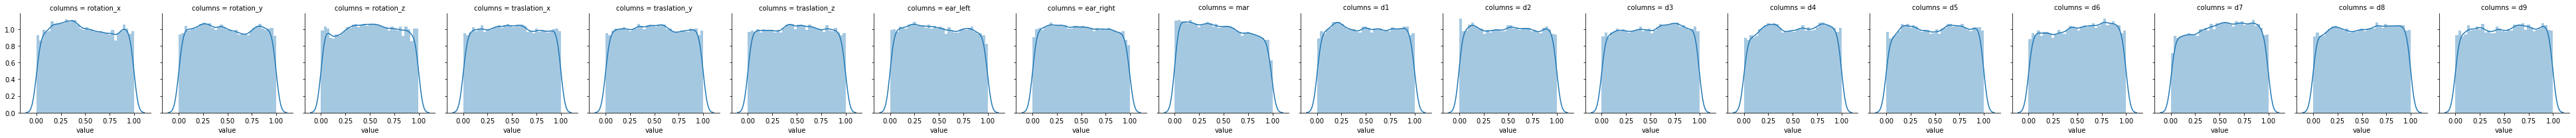

In [0]:
dfm = fake_complete_df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

### Reals

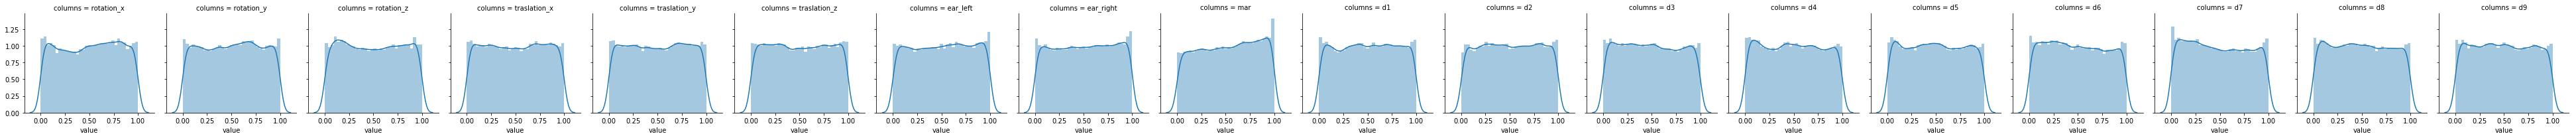

In [0]:
dfm = reals_complete_df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

### Deepfakes independently

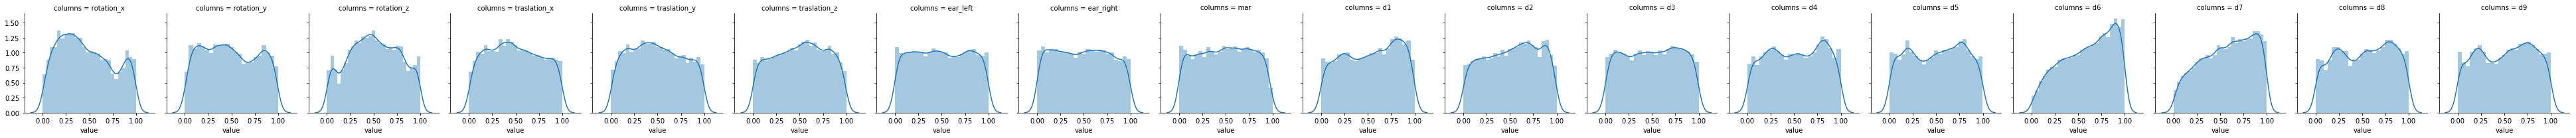

In [0]:
dfm = deep_fake_complete_df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

### FaceSwap independently


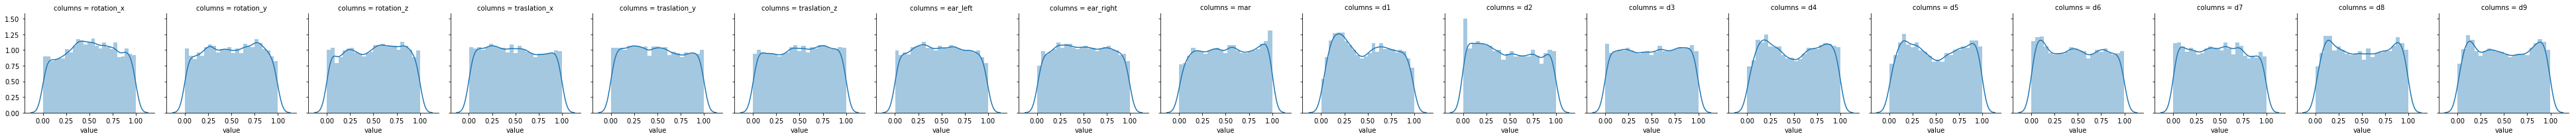

In [0]:
dfm = faceswap_complete_df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

### Face2Face independently

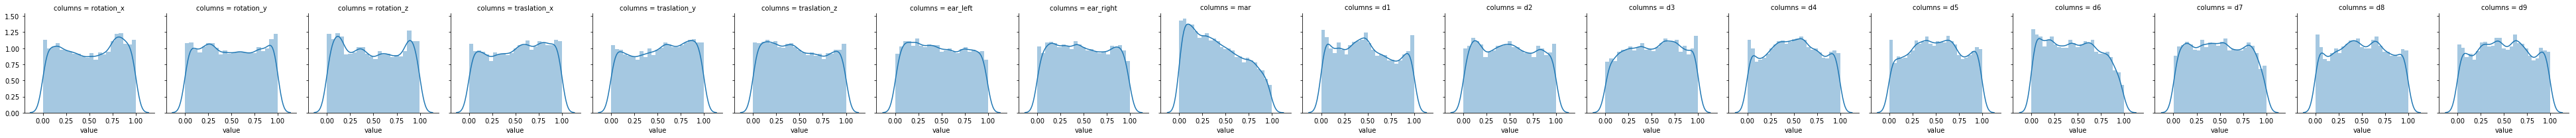

In [0]:
dfm = face2face_complete_df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))



---

## Write TFRecords files

In [0]:
def prepare_tf_block_b_sequence(features):
  return tf.train.Feature(float_list=tf.train.FloatList(value=np.reshape(features, [BLOCK_B_FEATURES_SHAPE[0]*BLOCK_B_FEATURES_SHAPE[1],])))

In [0]:
def prepare_tf_block_a_sequence(features):
  return tf.train.Feature(float_list=tf.train.FloatList(value=np.reshape(features, 
                                                                         [BLOCK_A_FEATURES_SHAPE[0]*BLOCK_A_FEATURES_SHAPE[1]*BLOCK_A_FEATURES_SHAPE[2]*BLOCK_A_FEATURES_SHAPE[3],])))

In [0]:
def prepare_tf_label(label):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[label]))

In [0]:
def prepare_tf_method(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

In [0]:
def build_tf_example(block_a_features, block_b_features, label, path, method):
  sequence_dict = {'faces': prepare_tf_block_a_sequence(block_a_features),
                   'distances': prepare_tf_block_b_sequence(block_b_features), 
                   'label':  prepare_tf_label(label),
                   'path':  prepare_tf_path(path),
                   'method': prepare_tf_method(method)}
  return tf.train.Example(features=tf.train.Features(feature=sequence_dict))

In [0]:
def prepare_tf_path(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

In [0]:
def build_tf_records(X_file, y_file, method_file, path_file, h5_file, tf_file, index_range):
  # Load block b data
  X = np.load(X_file)
  y = np.load(y_file)
  method = np.load(method_file)
  path = np.load(path_file)
  # Shuffle the data again
  #X, y, method, path = shuffle(X, y, method, path)
  # TF records writer
  train_writer = tf.python_io.TFRecordWriter(tf_file)
  # Read the block a features
  with h5py.File(h5_file, 'r') as f:
    # for each file
    for i in range(index_range[0], index_range[1]):
      print("video",i)
      # Build the tf record
      tf_example = build_tf_example(f[path[i]].value, X[i], y[i], path[i], method[i])
      # And write it at disk
      train_writer.write(tf_example.SerializeToString())
  train_writer.close()

In [0]:
REGEX = '\w+[_](\d+)[_](\d+)'
import re
p = re.compile(REGEX)


def build_tf_record_2(X_file, y_file, method_file, path_file, npy_folder, tf_folder):
  # Load block b data
  X = np.load(X_file)
  y = np.load(y_file)
  method = np.load(method_file)
  path = np.load(path_file)
  #mini-batches
  mini_batches_files = os.listdir(npy_folder)
  # get minibatches indexes
  for file in mini_batches_files:
    result = p.search(file)
    print(result.group(2))
    batch = np.load(os.path.join(npy_folder, file))
    writer = tf.python_io.TFRecordWriter(os.path.join(tf_folder, file.split('.')[0] + '.tfrecords'))
    z = 0
    print("batch",file)
    for i in range(int(result.group(1)),int(result.group(2))):
      tf_example = build_tf_example(batch[z], X[i], y[i], path[i], method[i])
      writer.write(tf_example.SerializeToString())
      z +=1
    writer.close()

In [0]:
build_tf_record_2(TRAIN_FEATURES['X'], TRAIN_FEATURES['y'], TRAIN_FEATURES['method'],
                 TRAIN_FEATURES['path'], os.path.join(DATASET_PATH, 'CROPPED_FACES/train/'), 
                  os.path.join(DATASET_PATH, 'tf_datasets/train/'))

In [0]:
build_tf_records(TRAIN_FEATURES['X'], TRAIN_FEATURES['y'], TRAIN_FEATURES['method'],
                 TRAIN_FEATURES['path'], TRAIN_H5PY_FILE_2, TRAIN_TF_RECORDS_2, (113, 226))

In [0]:
build_tf_records(TEST_FEATURES['X_t'], TEST_FEATURES['y_t'], TEST_FEATURES['method_t'],
                 TEST_FEATURES['path_t'], TEST_H5PY_FILE, TF_RECORDS['test'])

In [0]:
build_tf_records(VALIDATION_FEATURES['X_v'], VALIDATION_FEATURES['y_v'], VALIDATION_FEATURES['method_v'],
                 VALIDATION_FEATURES['path_v'], VALIDATION_H5PY_FILE, TF_RECORDS['val'])



---

## Read TFRecords files

In [0]:
def parse_sequence(sequence, block_a_shape = BLOCK_A_FEATURES_SHAPE, block_b_shape = BLOCK_B_FEATURES_SHAPE):
  sequence_features = {'faces': tf.FixedLenFeature(block_a_shape, dtype=tf.float32),
                       'distances': tf.FixedLenFeature(block_b_shape, dtype=tf.float32),
                       'path': tf.FixedLenFeature([], dtype=tf.string),
                       'method': tf.FixedLenFeature([], dtype=tf.string),
                       'label': tf.FixedLenFeature([1,], dtype=tf.float32)}
  sequence = tf.parse_single_example(sequence, features=sequence_features)
  return sequence['faces'], sequence['distances'], sequence['label'], sequence['path'], sequence['method']

In [0]:
def read_complete_features_batch(filename, shuffle_buffer_size = 100, batch_size = 3, num_parallel_calls = 8):
  dataset = tf.data.TFRecordDataset(filename).map(parse_sequence).repeat().batch(batch_size).prefetch(1)
  iterator = dataset.make_one_shot_iterator()
  block_a, block_b, label, _, _ = iterator.get_next()
  return block_a, block_b, label

In [0]:
def read_block_a_batch(filename, shuffle_buffer_size = 100, batch_size = 3, num_parallel_calls = 8):
  dataset = tf.data.TFRecordDataset(filename).map(parse_sequence).repeat().batch(batch_size).prefetch(1)
  iterator = dataset.make_one_shot_iterator()
  block_a, _, label, _, method = iterator.get_next()
  return block_a, label, method

In [0]:
def get_all_paths(folder):
  file_paths = []
  for folder, subs, files in os.walk(folder):
    for filename in files:
      file_paths.append(os.path.abspath(os.path.join(folder, filename)))
  return file_paths

In [0]:
def get_data_to_predict_block_a(filename, n_samples = 179):
  dataset = tf.data.TFRecordDataset(filename).map(parse_sequence)
  labels = np.empty((n_samples, ))
  iterator = dataset.make_one_shot_iterator()
  next_record = iterator.get_next()
  with tf.Session() as sess:
    for i in range(n_samples):
      _, _, labels[i], _, _ = sess.run(next_record)
  return labels

In [0]:
def get_data_to_predict_frames(filename, n_samples = 11991):
  dataset = tf.data.TFRecordDataset(filename).map(parse_frame)
  labels_1 = np.empty((n_samples, ))
  methods_1 = [None] * n_samples
  iterator = dataset.make_one_shot_iterator()
  next_record = iterator.get_next()
  with tf.Session() as sess:
    for i in range(n_samples):
      _, labels_1[i], methods_1[i] = sess.run(next_record)
  return labels_1, methods_1

In [0]:
def get_labels(labels, n_samples = 179):
  labels_1 = []
  with tf.Session() as sess:
    for i in range(n_samples):
      labels_1.append(sess.run(labels))
  return labels_1

In [0]:
def get_data_to_predict_frames(labels, steps = test_steps_per_epoch_1):
  labels_1 = []
  with tf.Session() as sess:
    for i in range(test_steps_per_epoch_1):
      labels_1.extend(sess.run(labels))
  return labels_1



---
## Xception Transfering Learning


In [0]:
"""build_frames_dataset(os.path.join(DATASET_PATH, 'CROPPED_FACES/train/'), os.path.join(DATASET_PATH, 'CROPPED_FACES/frames.hdf5'),TRAIN_FEATURES['y'])"""

In [0]:
"""build_frames_tf_records(os.path.join(DATASET_PATH, 'CROPPED_FACES/frames.hdf5'), os.path.join(DATASET_PATH, 'CROPPED_FACES/train'))"""

In [0]:
XCEPTION_VAL_MODEL = os.path.join(DATASET_PATH, 'convolutional_lstm_model/base_val_xception.h5')
XCEPTION_MODEL = os.path.join(DATASET_PATH, 'convolutional_lstm_model/base_xception.h5')
XCEPTION_HISTORY_ACC = os.path.join(DATASET_PATH, 'convolutional_lstm_model/base_xception_acc.npy')
XCEPTION_HISTORY_LOSS = os.path.join(DATASET_PATH, 'convolutional_lstm_model/base_xception_loss.npy')

In [0]:
"""X_frames = HDF5Matrix(os.path.join(DATASET_PATH, 'CROPPED_FACES/frames.hdf5'), 'X', start=0, end=45199) 
y_frames = HDF5Matrix(os.path.join(DATASET_PATH, 'CROPPED_FACES/frames.hdf5'), 'y', start=0, end=45199)"""

In [0]:
# Load a pretrained Xception model with Imaginet weights
xception_model = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=False, pooling = 'avg')
# We want to adjust the weights to our problem
xception_model.trainable = True
"""dense_layer_1 = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', 
                                           activity_regularizer=tf.keras.regularizers.l2(0.01))(xception_model.output) 
dropout_1 = tf.keras.layers.Dropout(0.5)(dense_layer_1)"""
costum_xception_output = tf.keras.layers.Dense(1, activation='sigmoid')(xception_model.output)
costum_xception_model = tf.keras.models.Model(xception_model.input, costum_xception_output)
costum_xception_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                                                 epsilon=None, decay=0.0, amsgrad=False),
                              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# TOTAL
N_INSTANCES_TRAIN = 43168
N_INSTANCES_VALIDATION = 4800 # 167 grupos
N_INSTANCES_TEST = 11991 # 167 grupos
BATCH_SIZE = 16

frames_train, labels_train = read_frames_batch(get_all_paths(train_frames_tfrecords), batch_size = BATCH_SIZE)
frames_val, labels_val = read_frames_batch(get_all_paths(val_frames_tfrecords), batch_size = BATCH_SIZE)
frames_test, labels_test = read_frames_batch(get_all_paths(test_frames_tfrecords), batch_size = BATCH_SIZE)

train_steps_per_epoch_1 = int(N_INSTANCES_TRAIN / BATCH_SIZE)
val_steps_per_epoch_1 = int(N_INSTANCES_VALIDATION / BATCH_SIZE)
test_steps_per_epoch_1 = int(N_INSTANCES_TEST / BATCH_SIZE)

In [0]:
# Define an early stopping callback to control overfitting
es_3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mcp_3 = tf.keras.callbacks.ModelCheckpoint(XCEPTION_VAL_MODEL, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
base_history = costum_xception_model.fit(frames_train, labels_train, steps_per_epoch = train_steps_per_epoch_1, validation_data = (frames_val, labels_val), 
                                         validation_steps = val_steps_per_epoch_1, epochs = 5, shuffle = 'batch', callbacks = [es_3, mcp_3])

costum_xception_model.save(XCEPTION_MODEL)
np.save(XCEPTION_HISTORY_ACC, base_history.history['loss'])
np.save(XCEPTION_HISTORY_LOSS, base_history.history['acc'])

In [0]:
xception_model_last_epoch = tf.keras.models.load_model(XCEPTION_MODEL)
xception_model_max_val = tf.keras.models.load_model(XCEPTION_VAL_MODEL)

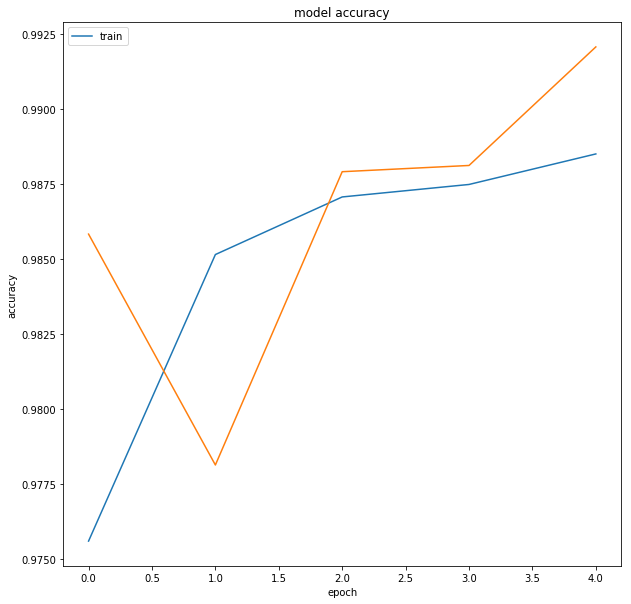

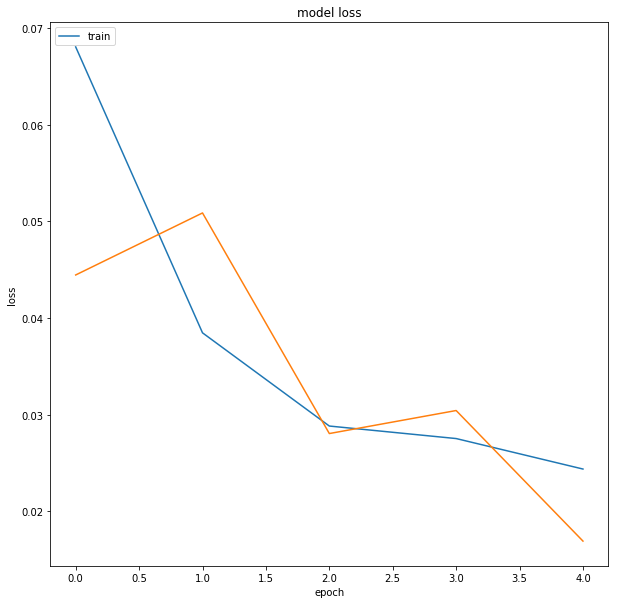

In [0]:
plt.figure(figsize=(10,10))
# summarize history for accuracy
plt.plot(base_history.history['acc'])
plt.plot(base_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.figure(figsize=(10,10))
# summarize history for loss
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
costum_xception_model.evaluate(frames_test, labels_test, steps = test_steps_per_epoch_1)

749/749 [==============================] - 239s 320ms/step - loss: 0.0168 - acc: 0.9916


[0.01678354284565172, 0.9915721]

In [0]:
xception_model_max_val.evaluate(frames_test, labels_test, steps = test_steps_per_epoch_1)

749/749 [==============================] - 238s 317ms/step - loss: 0.0168 - acc: 0.9916


[0.016783619126980773, 0.9915721]



---


## Block B Model (Landmarks features)

In [0]:
def build_model(lr, decay, rnn_units, batch_size, dense_unit_1, dense_unit_2,
                dropout, second_dense_layer, third_rnn_layer, gru_or_lstm, recurrent_dropout, l2):
  
  """
  1. Best: 0.522887 using {'lstm_units': 128, 'lr': 0.001, 'dropout': 0.1,
  'dense_unit_2': 64, 'dense_unit_1': 32, 'decay': 0.001, 'batch_size': 64}
  
  2. Best: 0.514085 using {'third_rnn_layer': False, 'second_dense_layer': False, 
  'rnn_units': 32, 'recurrent_dropout': 0.4, 'lr': 0.0001, 'l2': 0.1, 'gru_or_lstm': False,
  'dropout': 0.2, 'dense_unit_2': 128, 'dense_unit_1': 16, 'decay': 1e-06, 'batch_size': 4}
  3. Best: 0.534513 using {'third_rnn_layer': False, 'second_dense_layer': True, 'rnn_units': 128,
  'recurrent_dropout': 0.3, 'lr': 0.0001, 'l2': 0.01, 'gru_or_lstm': False, 'dropout': 0.4,
  'dense_unit_2': 16, 'dense_unit_1': 128, 'decay': 1e-08, 'batch_size': 64}
  
  """
  
  """
  https://danijar.com/tips-for-training-recurrent-neural-networks/
  https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/
  https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
  """
  
  ###############
  # DENSE BLOCK #
  ###############

  base_input = tf.keras.layers.Input(shape=(N_FEATURES,))
  base = tf.keras.layers.Dense(dense_unit_1, activation='relu', kernel_initializer='he_normal',
                               activity_regularizer=tf.keras.regularizers.l2(l2))(base_input)
  base = tf.keras.layers.Dropout(dropout)(base)
  base_output = tf.keras.layers.BatchNormalization()(base)
  base_model = tf.keras.models.Model(base_input, base_output)

  ##############
  # RNN BLOCK #
  ##############

  model_input = tf.keras.layers.Input(shape=(N_FRAMES, N_FEATURES))
  time_distributed = tf.keras.layers.TimeDistributed(base_model)(model_input)
  model = tf.keras.layers.LSTM(rnn_units,
                              return_sequences=True,
                              recurrent_dropout = recurrent_dropout, dropout = dropout)(time_distributed)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.LSTM(rnn_units,
                              return_sequences= False,
                              recurrent_dropout = recurrent_dropout, dropout = dropout)(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal',
                               activity_regularizer=tf.keras.regularizers.l2(l2))(model)
  model_output = tf.keras.layers.Dense(1, activation='sigmoid')(model)
  
  ###########
  # COMPILE #
  ###########
  
  # DEFINE INPUT AND OUTPUS
  final_model = tf.keras.models.Model(inputs=model_input, outputs=model_output)
  # COMPILE
  final_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr, decay=decay), loss='binary_crossentropy', metrics=['accuracy'])
  
  return final_model



---


### Hyperparameters Tuning

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

param_grid = {'lr': [1e-6, 1e-4, 1e-3, 1e-2, 1e-2, 1e-1], 'decay': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
             'rnn_units': [8, 12, 18, 32, 64, 128, 256], 'batch_size': [4, 8, 16, 32, 64, 128], 'dense_unit_1': [8, 12, 16, 32, 64, 128, 256],
             'dropout': [0.1, 0.2, 0.3, 0.4, 0.5], 'recurrent_dropout': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 'l2':[0.001, 0.01, 0.1, 0.0001]}


wrapper_model = KerasClassifier(build_fn=build_model, epochs=20, verbose=1)
rsearch = RandomizedSearchCV(estimator=wrapper_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, verbose = 2)
rsearch.fit(np.array(X), np.array(y))
print("Best: %f using %s" % (rsearch.best_score_, rsearch.best_params_))

In [0]:
print("Best: %f using %s" % (rsearch.best_score_, rsearch.best_params_))
best_model = rsearch.best_estimator_.model
best_model.save(TUNING_MODEL)



---


### Training

In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mcp = tf.keras.callbacks.ModelCheckpoint(TUNING_MODEL, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
"""
3. Best: 0.534513 using {'third_rnn_layer': False, 'second_dense_layer': True, 'rnn_units': 128,
  'recurrent_dropout': 0.3, 'lr': 0.0001, 'l2': 0.01, 'gru_or_lstm': False, 'dropout': 0.4,
  'dense_unit_2': 16, 'dense_unit_1': 128, 'decay': 1e-08, 'batch_size': 64}
"""

"""
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_45 (InputLayer)        [(None, 80, 18)]          0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 80, 32)            736       
_________________________________________________________________
lstm_12 (LSTM)               (None, 80, 128)           82432     
_________________________________________________________________
batch_normalization_68 (Batc (None, 80, 128)           512       
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_69 (Batc (None, 128)               512       
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
=================================================================
Total params: 224,097
Trainable params: 223,521
Non-trainable params: 576
____________________________

Epoch 133/1500
512/565 [==========================>...] - ETA: 0s - loss: 0.9020 - acc: 0.5527
Epoch 00133: val_acc improved from 0.63309 to 0.64029, saving model to gdrive/My Drive/TFM/DATASET/landmarks_features/tuning_model.h5

179/179 [==============================] - 2s 10ms/sample - loss: 0.8106 - acc: 0.5754
Test score: 0.810622378101562
Test accuracy: 0.575419

"""
final_model = build_model(lr = 0.0001, decay = 1e-7, rnn_units = 128, batch_size = 64, dense_unit_1 = 32, dense_unit_2 = 16,
                dropout = 0.5, second_dense_layer = True, third_rnn_layer = True, gru_or_lstm = False,
                          recurrent_dropout = 0.5, l2 = 0.01)
final_model.summary()
history = final_model.fit(x=np.array(X), y=np.array(y), epochs=1500, batch_size=64, 
                          validation_data = (np.array(X_v), np.array(y_v)), callbacks =[es, mcp])

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 80, 18)]          0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 80, 32)            736       
_________________________________________________________________
lstm_12 (LSTM)               (None, 80, 128)           82432     
_________________________________________________________________
batch_normalization_68 (Batc (None, 80, 128)           512       
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_69 (Batc (None, 128)               512       
_________________________________________________________________
dense_66 (Dense)             (None, 64)                825

In [0]:
np.save(HISTORY_LOSS, history.history['loss'])
np.save(HISTORY_ACC, history.history['acc'])

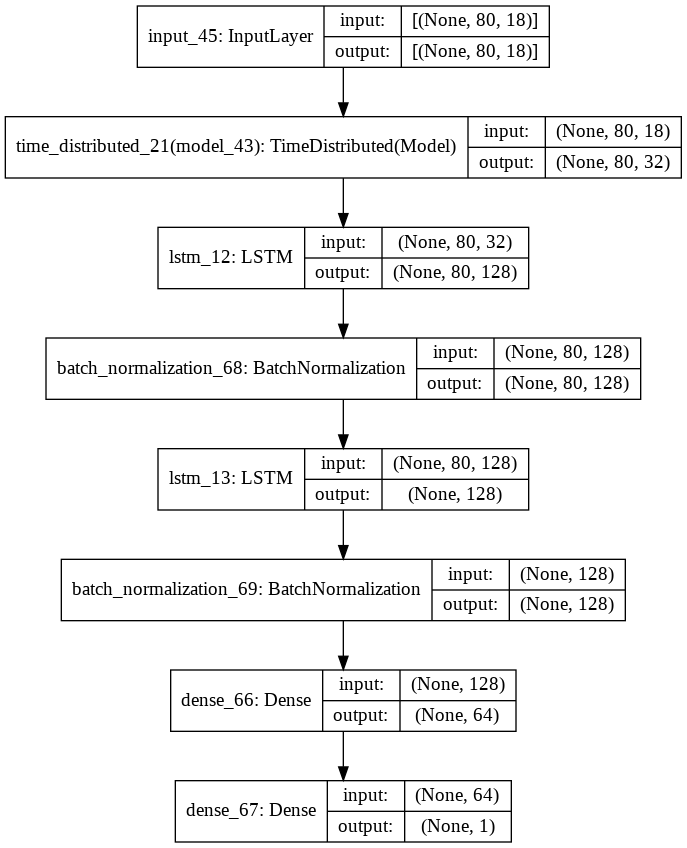

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(final_model, show_shapes=True, to_file='model.png')

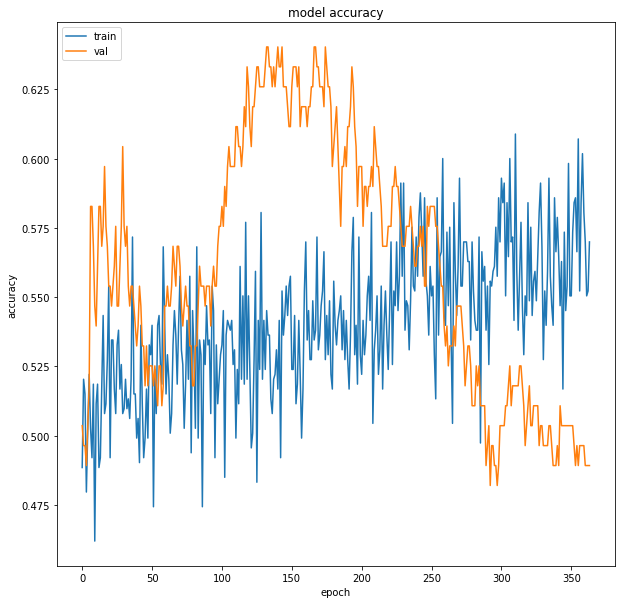

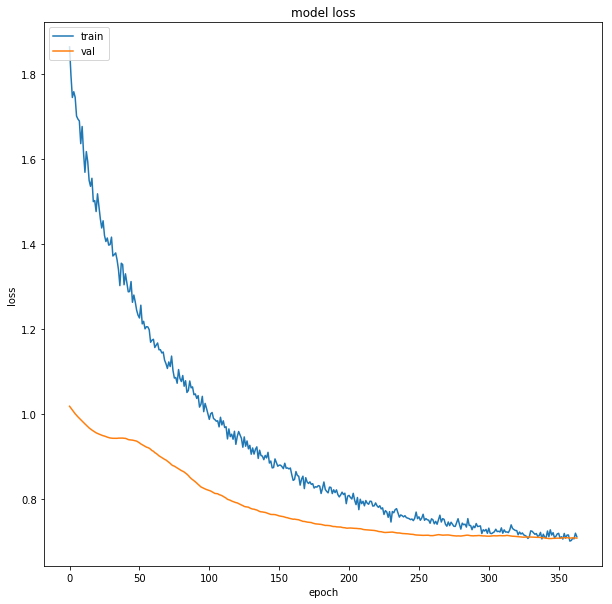

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



---

### Evaluation

In [0]:
max_val_model = tf.keras.models.load_model(TUNING_MODEL)

W0625 18:28:19.828382 140103825774464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 18:28:19.832422 140103825774464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 18:28:19.939913 140103825774464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

In [0]:
max_val_model.save(MODEL)

In [0]:
score, acc = final_model.evaluate(x=np.array(X_t), y=np.array(y_t), batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

179/179 [==============================] - 0s 2ms/sample - loss: 0.7243 - acc: 0.5531
Test score: 0.724317831034101
Test accuracy: 0.55307263


In [0]:
score, acc = max_val_model.evaluate(x=np.array(X_t), y=np.array(y_t), batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

179/179 [==============================] - 2s 10ms/sample - loss: 0.8106 - acc: 0.5754
Test score: 0.810622378101562
Test accuracy: 0.575419


**Get all predictions**

In [0]:
predictions = max_val_model.predict(np.array(X_t))

**Get predictions for each generation method and reals**

In [0]:
predictions_Deepfakes = predictions[np.append(np.where(method_t == "Deepfakes"), np.where(method_t == "Reals"))]
predictions_Faceswap = predictions[np.append(np.where(method_t == "FaceSwap"), np.where(method_t == "Reals"))]
predictions_Face2Face = predictions[np.append(np.where(method_t == "Face2Face"), np.where(method_t == "Reals"))]

y_Deepfakes = y_t[np.append(np.where(method_t == "Deepfakes"), np.where(method_t == "Reals"))]
y_Faceswap = y_t[np.append(np.where(method_t == "FaceSwap"), np.where(method_t == "Reals"))]
y_Face2Face = y_t[np.append(np.where(method_t == "Face2Face"), np.where(method_t == "Reals"))]

#### Get the classification report por each method type, reals, and general prediction

**1. General**



In [0]:
print(classification_report(np.array(y_t), np.array(predictions.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.60      0.45      0.51        89
        Fake       0.56      0.70      0.62        90

    accuracy                           0.58       179
   macro avg       0.58      0.57      0.57       179
weighted avg       0.58      0.58      0.57       179



In [0]:
accuracy_score(np.array(y_t), np.array(predictions.round()))

0.5754189944134078

**2. Deep fakes**

In [0]:
print(classification_report(np.array(y_Deepfakes), np.array(predictions_Deepfakes.round()), labels=[0., 1.], target_names=['Real', 'Deep Fakes']))

              precision    recall  f1-score   support

        Real       0.87      0.45      0.59        89
  Deep Fakes       0.33      0.80      0.47        30

    accuracy                           0.54       119
   macro avg       0.60      0.62      0.53       119
weighted avg       0.73      0.54      0.56       119



In [0]:
accuracy_score(np.array(y_Deepfakes), np.array(predictions_Deepfakes.round()))

0.5378151260504201

**3. Face2Face**

In [0]:
print(classification_report(np.array(y_Face2Face), np.array(predictions_Face2Face.round()), labels=[0., 1.], target_names=['Real', 'Face2Face']))

              precision    recall  f1-score   support

        Real       0.78      0.45      0.57        89
   Face2Face       0.28      0.63      0.39        30

    accuracy                           0.50       119
   macro avg       0.53      0.54      0.48       119
weighted avg       0.66      0.50      0.53       119



In [0]:
accuracy_score(np.array(y_Face2Face), np.array(predictions_Face2Face.round()))

0.4957983193277311

**4. FaceSwap**

In [0]:
print(classification_report(np.array(y_Faceswap), np.array(predictions_Faceswap.round()), labels=[1.], target_names=['FaceSwap']))

              precision    recall  f1-score   support

    FaceSwap       0.29      0.67      0.40        30

   micro avg       0.29      0.67      0.40        30
   macro avg       0.29      0.67      0.40        30
weighted avg       0.29      0.67      0.40        30



In [0]:
accuracy_score(np.array(y_Faceswap), np.array(predictions_Faceswap.round()))

0.5042016806722689

In [0]:
from sklearn.metrics import roc_curve

In [0]:
fpr, tpr, thresholds = roc_curve(np.array(y_t), np.array(predictions.round()))

In [0]:
from sklearn.metrics import auc

In [0]:
auc_value = auc(fpr, tpr)

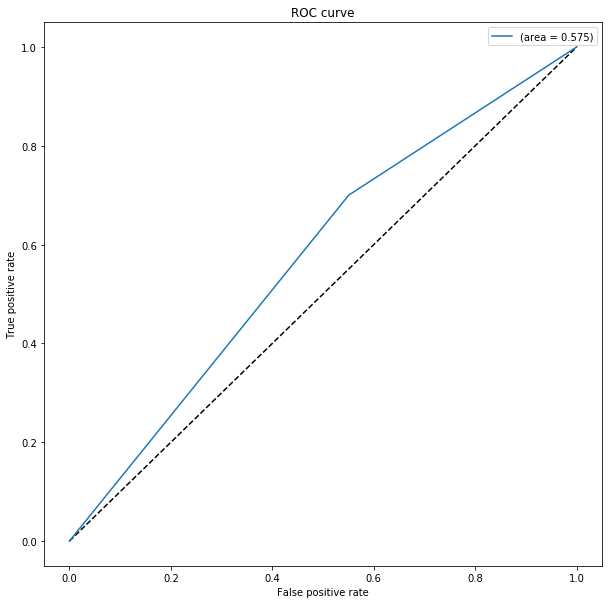

In [0]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



---

### Filtering features

In [0]:
###############
# DENSE BLOCK #
###############
"""
512/565 [==========================>...] - ETA: 0s - loss: 0.6738 - acc: 0.5957
Epoch 00144: val_acc improved from 0.59712 to 0.60432, saving model to gdrive/My Drive/TFM/DATASET/landmarks_features/model_b_tuning.h5
179/179 [==============================] - 1s 3ms/sample - loss: 0.6689 - acc: 0.6145
Test score: 0.6688835797363153
Test accuracy: 0.61452514
"""
dense_01_input = tf.keras.layers.Input(shape=(7,))
dense_01_output = tf.keras.layers.Dense(14, activation='relu', kernel_initializer='he_normal')(dense_01_input)
#dense_01_output = tf.keras.layers.Dropout(0.1)(dense_01)
#dense_01_output = tf.keras.layers.BatchNormalization()(dense_01)
dense_01_model = tf.keras.models.Model(dense_01_input, dense_01_output)

##############
# RNN BLOCK #
##############

lstm_input = tf.keras.layers.Input(shape=(80, 7))
lstm = tf.keras.layers.TimeDistributed(dense_01_model)(lstm_input)
#lstm = tf.keras.layers.BatchNormalization()(lstm)
"""
best results: 32 units
"""
lstm = tf.keras.layers.LSTM(32,return_sequences=False)(lstm)
#lstm = tf.keras.layers.BatchNormalization()(lstm)
"""lstm = tf.keras.layers.Dense(4, activation='relu', kernel_initializer='he_normal',
                               activity_regularizer=tf.keras.regularizers.l2(0.00001))(lstm)
lstm = tf.keras.layers.Dropout(0.1)(lstm)"""
lstm_output = tf.keras.layers.Dense(1, activation='sigmoid')(lstm)
  
###########
# COMPILE #
###########
  
# DEFINE INPUT AND OUTPUS
model_b = tf.keras.models.Model(inputs=lstm_input, outputs=lstm_output)
# COMPILE
model_b.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, decay=1e-7, amsgrad = False),
                loss='binary_crossentropy', metrics=['accuracy'])


In [0]:
es_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mcp_b = tf.keras.callbacks.ModelCheckpoint(MODEL_B_TUNING, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
X_c = np.delete(X, [0,1,2,3,4,5,9,10,13,16,17], axis = 2)

In [0]:
X_v_c = np.delete(X_v, [0,1,2,3,4,5,9,10,13,16,17], axis = 2)

In [0]:
X_t_c = np.delete(X_t, [0,1,2,3,4,5,9,10,13,16,17], axis = 2)

In [0]:
model_b.summary()
history_b = model_b.fit(x=np.array(X_c), y=np.array(y), epochs=2000, batch_size=64, 
                          validation_data = (np.array(X_v_c), np.array(y_v)), callbacks =[es_b, mcp_b])
model_b.save(MODEL_B)

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 80, 7)]           0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 80, 32)            256       
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________
Train on 565 samples, validate on 139 samples
Epoch 1/2000
512/565 [==========================>...] - ETA: 0s - loss: 0.7037 - acc: 0.4863
Epoch 00001: val_acc did not improve from 0.62590
565/565 [==============================] - 5s 8ms/sample - loss: 

In [0]:
score, acc = model_b.evaluate(x=np.array(X_t_c), y=np.array(y_t), batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

179/179 [==============================] - 0s 840us/sample - loss: 0.6708 - acc: 0.5698
Test score: 0.670766695251678
Test accuracy: 0.5698324


In [0]:
max_val_model_b = tf.keras.models.load_model(MODEL_B_BEST)

In [0]:
score, acc = max_val_model_b.evaluate(x=np.array(X_t_c), y=np.array(y_t), batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

179/179 [==============================] - 1s 5ms/sample - loss: 0.6689 - acc: 0.6145
Test score: 0.6688835797363153
Test accuracy: 0.61452514


In [0]:
predictions_b = max_val_model_b.predict(np.array(X_t_c))

In [0]:
print(classification_report(np.array(y_t), np.array(predictions_b.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.62      0.60      0.61        89
        Fake       0.61      0.63      0.62        90

    accuracy                           0.61       179
   macro avg       0.61      0.61      0.61       179
weighted avg       0.61      0.61      0.61       179



In [0]:
"""max_val_model_b.save(MODEL_B_BEST)"""

In [0]:
fpr_b, tpr_b, thresholds_b = roc_curve(np.array(y_t), np.array(predictions_b.round()))
auc_value_b = auc(fpr_b, tpr_b)

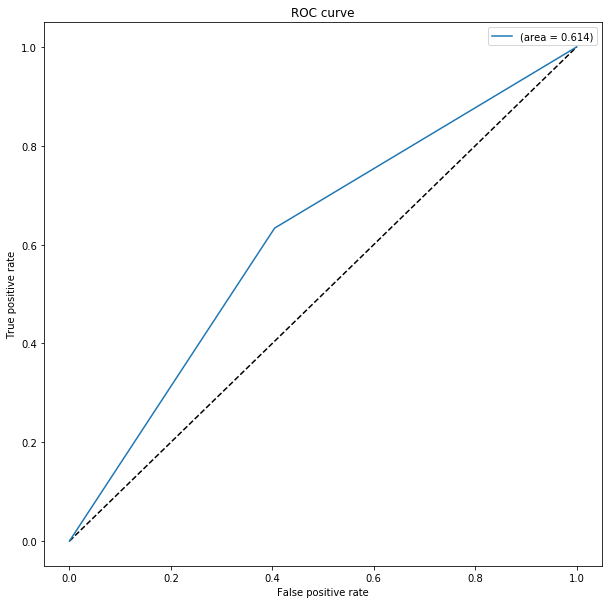

In [0]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_b, tpr_b, label='(area = {:.3f})'.format(auc_value_b))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

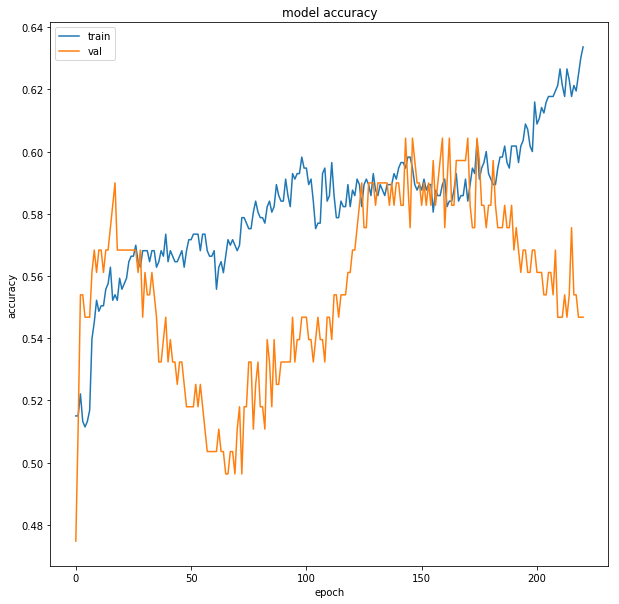

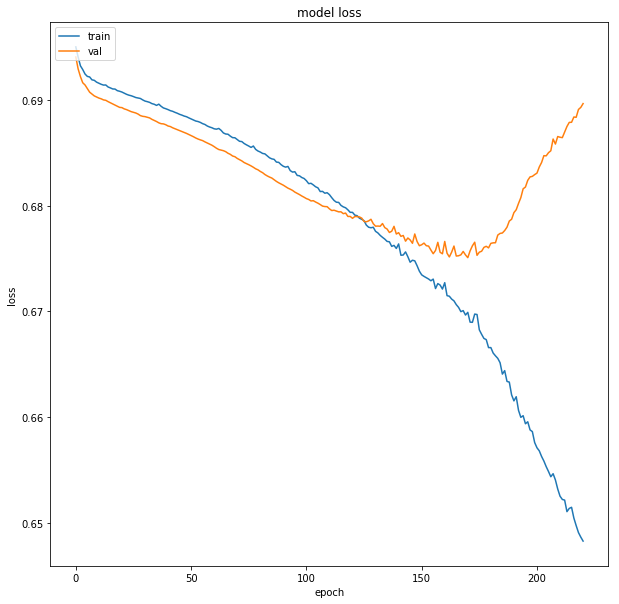

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# summarize history for accuracy
plt.plot(history_b.history['acc'])
plt.plot(history_b.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10,10))
plt.plot(history_b.history['loss'])
plt.plot(history_b.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
predictions_Deepfakes_b = predictions_b[np.append(np.where(method_t == "Deepfakes"), np.where(method_t == "Reals"))]
predictions_Faceswap_b = predictions_b[np.append(np.where(method_t == "FaceSwap"), np.where(method_t == "Reals"))]
predictions_Face2Face_b = predictions_b[np.append(np.where(method_t == "Face2Face"), np.where(method_t == "Reals"))]

y_Deepfakes_b = y_t[np.append(np.where(method_t == "Deepfakes"), np.where(method_t == "Reals"))]
y_Faceswap_b = y_t[np.append(np.where(method_t == "FaceSwap"), np.where(method_t == "Reals"))]
y_Face2Face_b = y_t[np.append(np.where(method_t == "Face2Face"), np.where(method_t == "Reals"))]

In [0]:
print(classification_report(np.array(y_Deepfakes_b), np.array(predictions_Deepfakes_b.round()), labels=[0., 1.], target_names=['Real', 'Deep Fakes']))

              precision    recall  f1-score   support

        Real       0.84      0.60      0.70        89
  Deep Fakes       0.36      0.67      0.47        30

    accuracy                           0.61       119
   macro avg       0.60      0.63      0.58       119
weighted avg       0.72      0.61      0.64       119



In [0]:
print(classification_report(np.array(y_Faceswap_b), np.array(predictions_Faceswap_b.round()), labels=[0., 1.], target_names=['Real', 'FaceSwap']))

              precision    recall  f1-score   support

        Real       0.79      0.60      0.68        89
    FaceSwap       0.31      0.53      0.39        30

    accuracy                           0.58       119
   macro avg       0.55      0.56      0.53       119
weighted avg       0.67      0.58      0.61       119



In [0]:
print(classification_report(np.array(y_Face2Face_b), np.array(predictions_Face2Face_b.round()), labels=[0., 1.], target_names=['Real', 'Face2Face']))

              precision    recall  f1-score   support

        Real       0.85      0.60      0.70        89
   Face2Face       0.37      0.70      0.48        30

    accuracy                           0.62       119
   macro avg       0.61      0.65      0.59       119
weighted avg       0.73      0.62      0.65       119



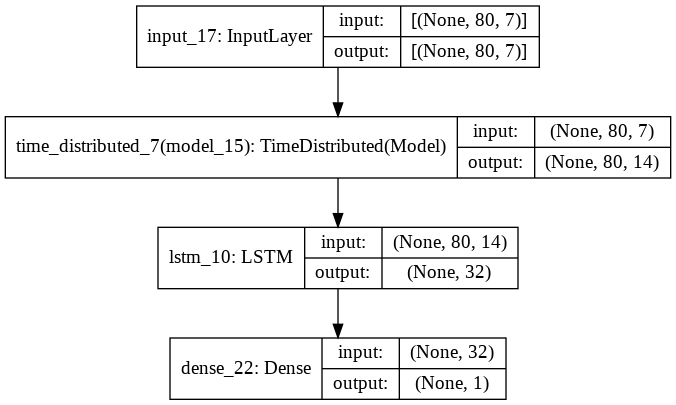

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(max_val_model_b, show_shapes=True, to_file='model.png')



---

## Block A Model (Convolutional LSTM)

In [0]:
X, y, _ = read_block_a_batch(get_all_paths(os.path.join(DATASET_PATH, 'tf_datasets/train/')))
X_v, y_v, _ = read_block_a_batch(TF_RECORDS['val'])
X_t, y_t, _ = read_block_a_batch(TF_RECORDS['test'])

### Convolutional LSTM

In [0]:
VAL_MODEL_CNN_LSTM = os.path.join(DATASET_PATH, 'convolutional_lstm_model/val_model.h5')
MODEL_CNN_LSTM = os.path.join(DATASET_PATH, 'convolutional_lstm_model/train_model.h5')
HISTORY_ACC_1 = os.path.join(DATASET_PATH, 'convolutional_lstm_model/history_acc.npy')
HISTORY_LOSS_1 = os.path.join(DATASET_PATH, 'convolutional_lstm_model/history_loss.npy')
HISTORY_ACC_VAL_1 = os.path.join(DATASET_PATH, 'convolutional_lstm_model/history_acc_val.npy')
HISTORY_LOSS_VAL_1 = os.path.join(DATASET_PATH, 'convolutional_lstm_model/history_loss_val.npy')

In [0]:
# Load a pretrained Xception model with Imaginet weights
xception_model = tf.keras.models.load_model(XCEPTION_MODEL)

In [0]:
# We want to adjust the weights to our problem
xception_model.trainable = False

In [0]:
xception_model.summary()

W0702 06:55:03.156774 139906610091904 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:

xception_output = xception_model.get_layer('global_average_pooling2d_2').output
time_projection_space_xception = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(xception_output)
dropout_9 = tf.keras.layers.Dropout(0.5)(time_projection_space_xception)
xception_model_dense_output = tf.keras.models.Model(inputs=xception_model.input, outputs=dropout_9)

In [0]:
"""xception_model.layers.pop()
xception_model.layers.pop()"""
xception_model_dense_output.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
"""
DEFINE MODEL LAYERS
"""
# RGB images sequence input
costum_xception_input = tf.keras.layers.Input(shape=(80, 299, 299, 3))
# Distribute the average output in time steps
costum_xception_time_distributed = tf.keras.layers.TimeDistributed(xception_model_dense_output)(costum_xception_input)    
# Define a GRU layer to capture time patterns
costum_xception_lstm_1 = tf.keras.layers.LSTM(256, dropout = 0.5, recurrent_dropout=0.5, return_sequences = False)(costum_xception_time_distributed)
# Finally a few dense layers with a sigmoid activation function as output
# for binary classification
dense_2 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(costum_xception_lstm_1)
dropout_2 = tf.keras.layers.Dropout(0.5)(dense_2)
costum_xception_output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)
"""
BUILD MODEL AND COMPILE
"""
costum_xception_model = tf.keras.models.Model(costum_xception_input, costum_xception_output)
costum_xception_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9,
                                                                 beta_2=0.999, decay=1e-5,
                                                                 amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
costum_xception_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 299, 299, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 256)           21386024  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 21,944,361
Trainable params: 1,082,881
Non-trainable params: 20,861,480
_______________________________________

In [0]:
# Define an early stopping callback to control overfitting
es_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mcp_2 = tf.keras.callbacks.ModelCheckpoint(VAL_MODEL_CNN_LSTM, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
BATCH_SIZE = 3
N_TRAIN_SAMPLES = 565
N_VALIDATION_SAMPLES = 139
N_TEST_SAMPLES = 179
train_steps_per_epoch = int(N_TRAIN_SAMPLES / BATCH_SIZE) 
test_steps_per_epoch = int(N_TEST_SAMPLES / BATCH_SIZE)
validation_steps_per_epoch = int(N_VALIDATION_SAMPLES / BATCH_SIZE)

In [0]:
"""history_1 = costum_xception_model.fit(X, y, epochs = 20, validation_data = (X_v, y_v),
                                      steps_per_epoch = train_steps_per_epoch, validation_steps = validation_steps_per_epoch,
                                     callbacks=[es_2, mcp_2])"""
history_1 = costum_xception_model.fit(X, y, epochs = 50, steps_per_epoch = train_steps_per_epoch,
                                      validation_data = (X_v, y_v), validation_steps = validation_steps_per_epoch, callbacks =[es_2, mcp_2],
                                     shuffle='batch')
#history_1 = costum_xception_model.fit(X, y, epochs = 5, steps_per_epoch = train_steps_per_epoch)
costum_xception_model.save(MODEL_CNN_LSTM)
np.save(HISTORY_LOSS_1, history_1.history['loss'])
np.save(HISTORY_ACC_1, history_1.history['acc'])

Epoch 1/50
187/188 [============================>.] - ETA: 3s - loss: 0.5992 - acc: 0.7380
Epoch 00001: val_acc improved from -inf to 0.86957, saving model to gdrive/My Drive/TFM/DATASET/convolutional_lstm_model/val_model.h5
188/188 [==============================] - 734s 4s/step - loss: 0.5983 - acc: 0.7394 - val_loss: 0.6216 - val_acc: 0.8696
Epoch 2/50
187/188 [============================>.] - ETA: 2s - loss: 0.4422 - acc: 0.8948
Epoch 00002: val_acc improved from 0.86957 to 0.88406, saving model to gdrive/My Drive/TFM/DATASET/convolutional_lstm_model/val_model.h5
188/188 [==============================] - 516s 3s/step - loss: 0.4427 - acc: 0.8954 - val_loss: 0.5485 - val_acc: 0.8841
Epoch 3/50
187/188 [============================>.] - ETA: 2s - loss: 0.3334 - acc: 0.9037
Epoch 00003: val_acc improved from 0.88406 to 0.91304, saving model to gdrive/My Drive/TFM/DATASET/convolutional_lstm_model/val_model.h5
188/188 [==============================] - 520s 3s/step - loss: 0.3329 - ac

In [0]:
history_1_loss = np.load(HISTORY_LOSS_1)
history_1_acc = np.load(HISTORY_ACC_1)

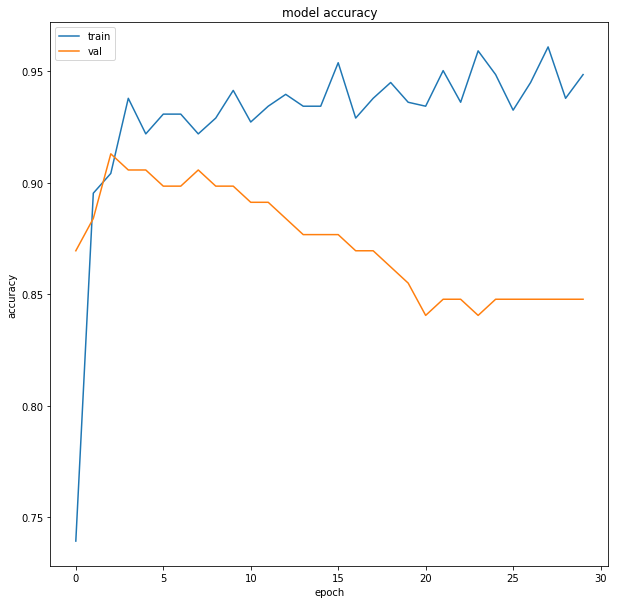

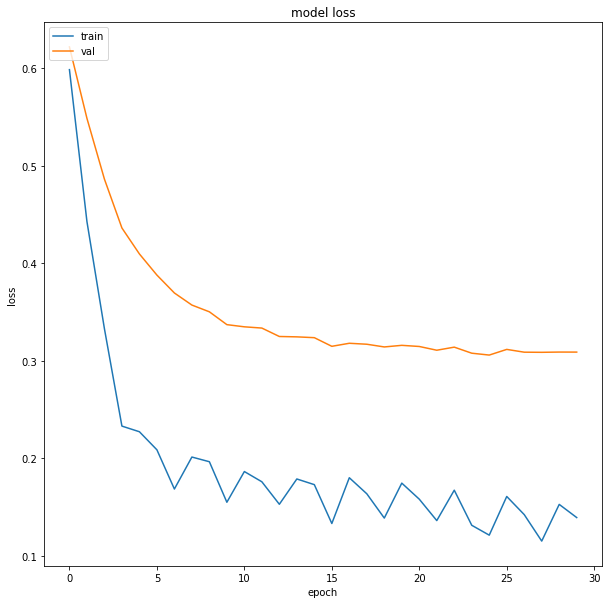

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# summarize history for accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10,10))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



---

#### Evaluation

In [0]:
X_t_1, y_t_1, method_t_1 = read_block_a_batch(TF_RECORDS['test'], batch_size = 1)

W0705 09:08:26.513170 140617239201664 deprecation.py:323] From <ipython-input-8-6c15dd797d3c>:3: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
labels = get_labels(y_t_1)

In [0]:
methods = get_labels(method_t_1)

In [0]:
for i in range(len(methods)):
    methods[i] = methods[i][0].decode('utf-8')

In [0]:
labels = np.squeeze(labels)

In [0]:
costum_xception_model = tf.keras.models.load_model(MODEL_CNN_LSTM)

In [0]:
costum_xception_model.evaluate(X_t, y_t, steps = test_steps_per_epoch)

59/59 [==============================] - 121s 2s/step - loss: 0.2479 - acc: 0.9040


[0.24793890418516376, 0.9039548]

In [0]:
val_lstm_xception_model = tf.keras.models.load_model(VAL_MODEL_CNN_LSTM)

W0705 09:12:37.246876 140617239201664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0705 09:12:37.248497 140617239201664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0705 09:12:37.255059 140617239201664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

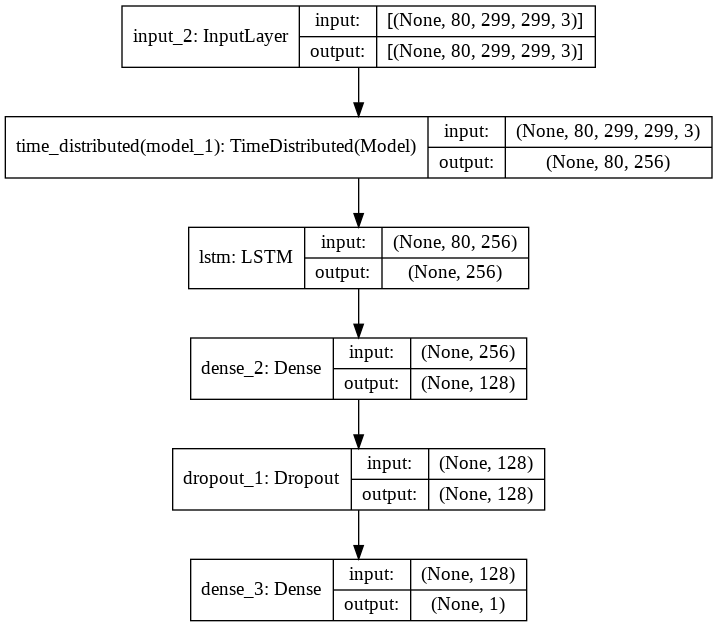

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(val_lstm_xception_model, show_shapes=True, to_file='model.png')

In [0]:
val_lstm_xception_model.evaluate(X_t, y_t, steps = test_steps_per_epoch)

59/59 [==============================] - 126s 2s/step - loss: 0.4808 - acc: 0.9379


[0.48079338114140396, 0.9378531]

In [0]:
_,_,mark = get_random_sequence(os.path.join(DATASET_PATH, 'fire_test/Zuckerberg.mp4'))

In [0]:
_,_,lawrence = get_random_sequence(os.path.join(DATASET_PATH, 'fire_test/Lawrence.mp4'))

In [0]:
_,_,obama = get_random_sequence(os.path.join(DATASET_PATH, 'fire_test/Obama.mp4'))

In [0]:
_,_,me = get_random_sequence(os.path.join(DATASET_PATH, 'fire_test/Me.mp4'))

In [0]:
_,_,yhq = get_random_sequence(os.path.join(DATASET_PATH, 'fire_test/YoutuberHQ.mp4'))

In [0]:
_,_,ylq = get_random_sequence(os.path.join(DATASET_PATH, 'fire_test/YoutubeLQ.mp4'))

In [0]:
fire_test = np.empty((1,80,299,299,3))
fire_test[0] = mark
"""fire_test[1] = lawrence"""
"""fire_test[2] = obama
fire_test[3] = me"""
"""fire_test[2] = yhq
fire_test[3] = ylq"""

'fire_test[2] = yhq\nfire_test[3] = ylq'

In [0]:
if val_lstm_xception_model.predict(fire_test)[0].round() == 1.0:
  print('Fake')

Fake


In [0]:
predictions = costum_xception_model.predict(X_t_1, steps = 179)

In [0]:
predictions_val = val_lstm_xception_model.predict(X_t_1, steps = 179)

In [0]:
predictions_Deepfakes_b = predictions_val[np.append(np.where(np.array(methods) == "Deepfakes"), np.where(np.array(methods) == "Reals"))]
predictions_Faceswap_b = predictions_val[np.append(np.where(np.array(methods) == "FaceSwap"), np.where(np.array(methods) == "Reals"))]
predictions_Face2Face_b = predictions_val[np.append(np.where(np.array(methods) == "Face2Face"), np.where(np.array(methods) == "Reals"))]

y_Deepfakes_b = labels[np.append(np.where(np.array(methods) == "Deepfakes"), np.where(np.array(methods) == "Reals"))]
y_Faceswap_b = labels[np.append(np.where(np.array(methods) == "FaceSwap"), np.where(np.array(methods) == "Reals"))]
y_Face2Face_b = labels[np.append(np.where(np.array(methods) == "Face2Face"), np.where(np.array(methods) == "Reals"))]

In [0]:
print(classification_report(np.array(y_Deepfakes_b), np.array(predictions_Deepfakes_b.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.97      0.96      0.96        89
        Fake       0.87      0.90      0.89        30

    accuracy                           0.94       119
   macro avg       0.92      0.93      0.92       119
weighted avg       0.94      0.94      0.94       119



In [0]:
fpr_df, tpr_df, thresholds_df = roc_curve(np.array(y_Deepfakes_b), np.array(predictions_Deepfakes_b.round()))
auc_value_df = auc(fpr_df, tpr_df)

In [0]:
auc_value_df

0.9275280898876404

In [0]:
print(classification_report(np.array(y_Faceswap_b), np.array(predictions_Faceswap_b.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.98      0.96      0.97        89
        Fake       0.88      0.93      0.90        30

    accuracy                           0.95       119
   macro avg       0.93      0.94      0.93       119
weighted avg       0.95      0.95      0.95       119



In [0]:
fpr_f2f, tpr_f2f, thresholds_f2f = roc_curve(np.array(y_Faceswap_b), np.array(predictions_Faceswap_b.round()))
auc_value_f2f = auc(fpr_f2f, tpr_f2f)
auc_value_f2f

0.9441947565543072

In [0]:
print(classification_report(np.array(y_Face2Face_b), np.array(predictions_Face2Face_b.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.98      0.96      0.97        89
        Fake       0.88      0.93      0.90        30

    accuracy                           0.95       119
   macro avg       0.93      0.94      0.93       119
weighted avg       0.95      0.95      0.95       119



In [0]:
fpr_fs, tpr_fs, thresholds_fs = roc_curve(np.array(y_Face2Face_b), np.array(predictions_Face2Face_b.round()))
auc_value_fs = auc(fpr_fs, tpr_fs)
auc_value_fs

0.9441947565543072

In [0]:
print(classification_report(np.array(labels), np.array(predictions.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.99      0.82      0.90        89
        Fake       0.85      0.99      0.91        90

    accuracy                           0.91       179
   macro avg       0.92      0.90      0.90       179
weighted avg       0.92      0.91      0.90       179



In [0]:
print(classification_report(np.array(labels), np.array(predictions_val.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.92      0.96      0.94        89
        Fake       0.95      0.92      0.94        90

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179



In [0]:
print(classification_report(np.array(labels), np.array(predictions_val.round()), labels=[0., 1.], target_names=['Real', 'Fake']))

In [0]:
fpr_a, tpr_a, thresholds_a = roc_curve(np.array(labels), np.array(predictions.round()))
auc_value_a = auc(fpr_a, tpr_a)

In [0]:
fpr_a_val, tpr_a_val, thresholds_a_val = roc_curve(np.array(labels), np.array(predictions_val.round()))
auc_value_a_val = auc(fpr_a_val, tpr_a_val)

In [0]:
auc_value_a, auc_value_a_val

(0.9045568039950063, 0.9386392009987516)

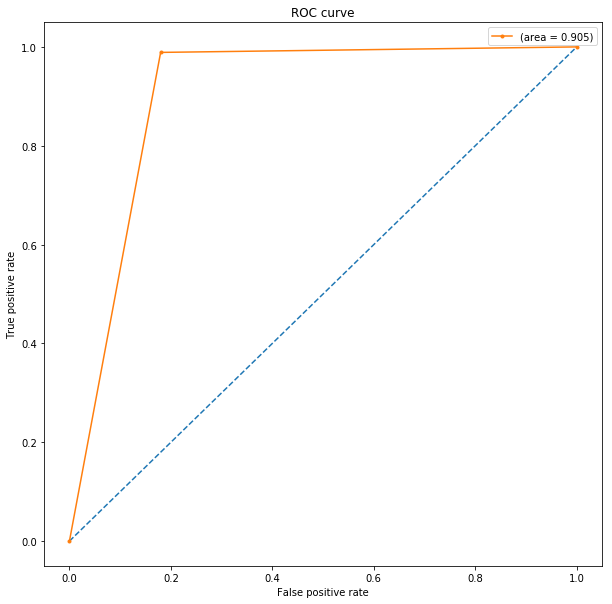

In [0]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_a, tpr_a, marker='.', label='(area = {:.3f})'.format(auc_value_a))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

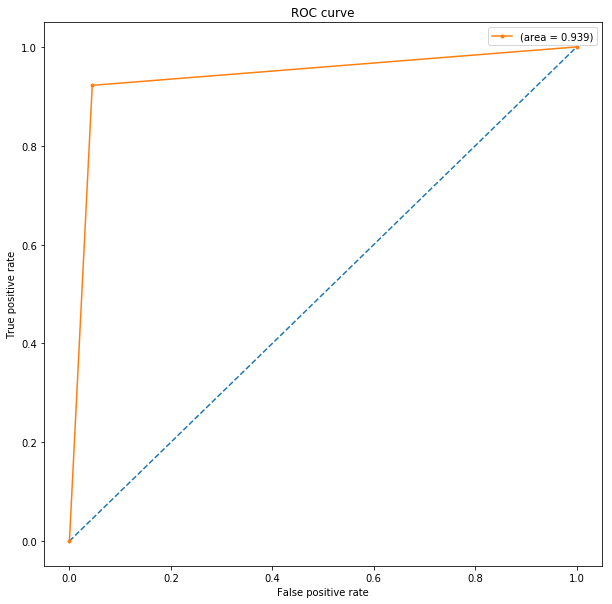

In [0]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_a_val, tpr_a_val, marker='.', label='(area = {:.3f})'.format(auc_value_a_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



---


## Final model

### Import data

In [0]:
# Load dataset
"""X_t_b = np.load(TEST_FEATURES['X_t'])
X_t_b = np.delete(X_t_b, [0,1,2,3,4,5,9,10,13,16,17], axis = 2)"""
"""y_t = np.load(TEST_FEATURES['y_t'])
method_t = np.load(TEST_NN_FEATURES['method_t'])
path_t = np.load(TEST_NN_FEATURES['path_t'])"""
"""
X_b = np.load(TRAIN_FEATURES['X'])
X_b = np.delete(X_b, [0,1,2,3,4,5,9,10,13,16,17], axis = 2)"""
"""method =np.load(TRAIN_FEATURES['method'])
path =np.load(TRAIN_FEATURES['path'])"""

"""X_v_b = np.load(VALIDATION_FEATURES['X_v'])
X_v_b = np.delete(X_v_b, [0,1,2,3,4,5,9,10,13,16,17], axis = 2)"""
"""
y_v = np.load(VALIDATION_FEATURES['y_v'])
method_v =np.load(VALIDATION_FEATURES['method_v'])"""

"\ny_v = np.load(VALIDATION_FEATURES['y_v'])\nmethod_v =np.load(VALIDATION_FEATURES['method_v'])"

In [0]:
def prepare_tf_block_b_sequence(sequence):
  return tf.train.Feature(float_list=tf.train.FloatList(value=np.reshape(sequence, [80*7,])))
def build_tf_example_block_b(sequence):
  sequence_dict = {'features': prepare_tf_block_b_sequence(sequence)}
  return tf.train.Example(features=tf.train.Features(feature=sequence_dict))
def build_tf_records_block_b(X, tf_file):
  train_writer = tf.python_io.TFRecordWriter(tf_file)
  for x in X:
    tf_example = build_tf_example_block_b(x)
    train_writer.write(tf_example.SerializeToString())
  train_writer.close()
  
def parse_tf_block_b_sequence(sequence):
  sequence_features = {'features': tf.FixedLenFeature((80, 7), dtype=tf.float32)}
  sequence = tf.parse_single_example(sequence, features=sequence_features)
  return sequence['features']
def read_block_b_batch(filename, shuffle_buffer_size = 100, batch_size = 3, num_parallel_calls = 8):
  dataset = tf.data.TFRecordDataset(filename).map(parse_tf_block_b_sequence).repeat().batch(batch_size).prefetch(1)
  iterator = dataset.make_one_shot_iterator()
  block_b = iterator.get_next()
  return block_b

In [0]:
"""build_tf_records_block_b(X_b,  os.path.join(DATASET_PATH, 'tf_datasets/block_b.tfrecords'))"""

In [0]:
"""build_tf_records_block_b(X_t_b,  os.path.join(DATASET_PATH, 'tf_datasets/block_b_test.tfrecords'))"""

In [0]:
"""build_tf_records_block_b(X_v_b,  os.path.join(DATASET_PATH, 'tf_datasets/block_b_val.tfrecords'))"""

In [0]:
X_b =  read_block_b_batch(os.path.join(DATASET_PATH, 'tf_datasets/block_b.tfrecords'))
X_t_b =  read_block_b_batch(os.path.join(DATASET_PATH, 'tf_datasets/block_b_test.tfrecords'))
X_v_b =  read_block_b_batch(os.path.join(DATASET_PATH, 'tf_datasets/block_b_val.tfrecords'))

### Import block A model

In [0]:
base_block_a_model = tf.keras.models.load_model(TUNING_MODEL_2)

In [0]:
base_block_a_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 299, 299, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 256)           21386024  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 21,944,361
Trainable params: 1,082,881
Non-trainable params: 20,861,480
_______________________________________

In [0]:
block_a_model = tf.keras.models.Model(inputs=base_block_a_model.input, outputs=base_block_a_model.get_layer('dropout_2').output)

In [0]:
block_a_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 299, 299, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 256)           21386024  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
Total params: 21,944,232
Trainable params: 1,082,752
Non-trainable params: 20,861,480
_________________________________________________________________


### Import block B model

In [0]:
base_block_b_model = tf.keras.models.load_model(MODEL_B_BEST)

In [0]:
base_block_b_model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 80, 7)]           0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 80, 14)            112       
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6016      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________


In [0]:
block_b_model = tf.keras.models.Model(inputs=base_block_b_model.input, outputs=base_block_b_model.get_layer('lstm_10').output)

In [0]:
block_b_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 80, 7)]           0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 80, 14)            112       
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6016      
Total params: 6,128
Trainable params: 6,128
Non-trainable params: 0
_________________________________________________________________


### Concatenate inputs

In [0]:
merge = tf.keras.layers.concatenate([block_a_model.output, block_b_model.output])
dense_4 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(merge)
drop_out_2 = tf.keras.layers.Dropout(0.5)(dense_4)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(drop_out_2)

"""
COMPILE
"""
# DEFINE INPUT AND OUTPUS
final_model = tf.keras.models.Model(inputs=[block_a_model.input, block_b_model.input], outputs=output_layer)
# COMPILE
final_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9,
                                                                 beta_2=0.999, decay=1e-7,
                                                                 amsgrad=False), loss='binary_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 299, 299 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 80, 256)      21386024    input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256)          525312      time_distributed[0][0]           
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 80, 7)]      0                                            
____________________________________________________________________________________________

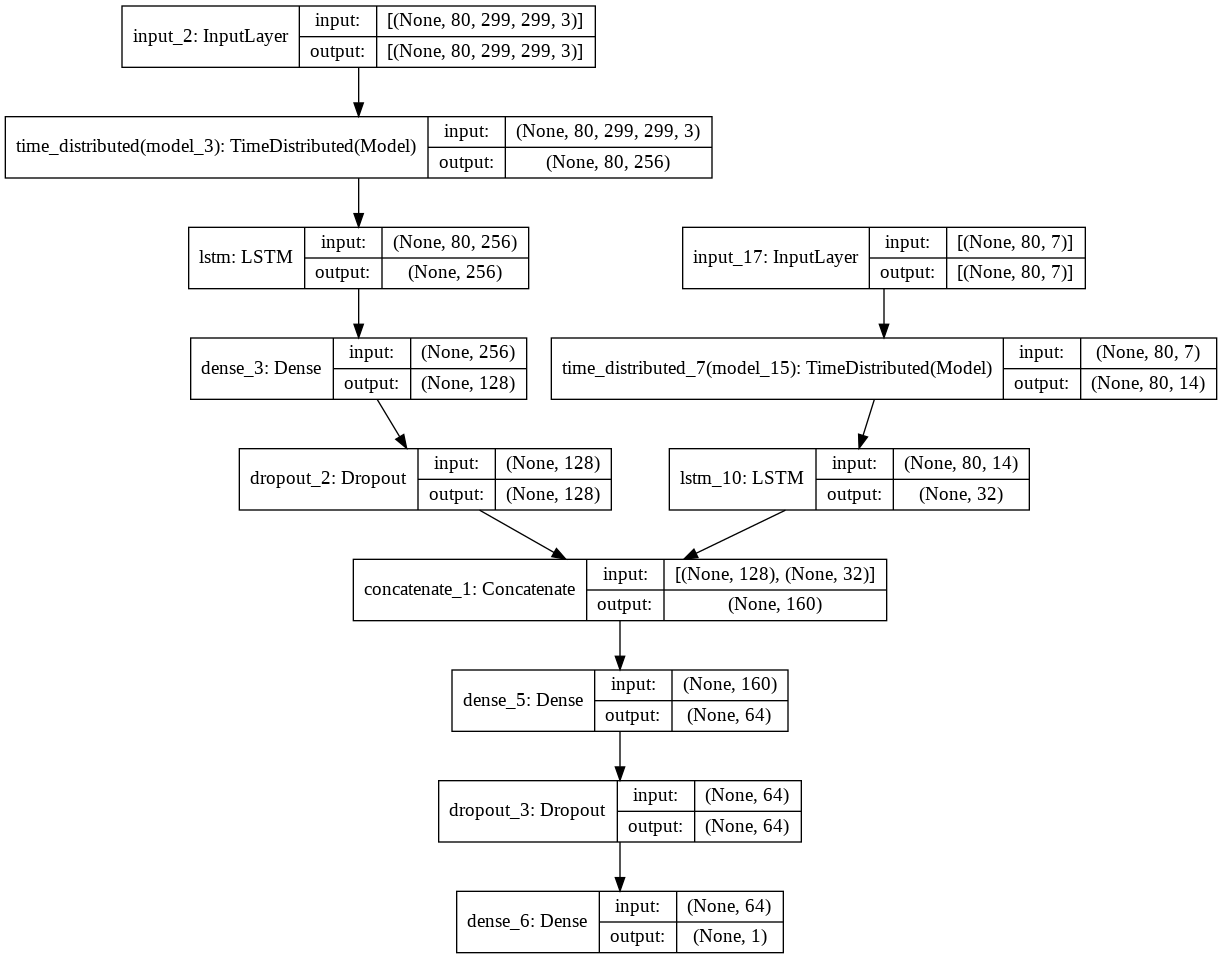

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(final_model, to_file='model_1.png',\
           show_shapes=True, show_layer_names=True)

In [0]:
# Define an early stopping callback to control overfitting
es_4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mcp_4 = tf.keras.callbacks.ModelCheckpoint(TUNING_MODEL_2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
FINAL_MODEL_VAL = os.path.join(DATASET_PATH, 'final_model/final_model_val.h5')
FINAL_MODEL = os.path.join(DATASET_PATH, 'final_model/final_model.h5')

FINAL_FISTORY_LOSS = os.path.join(DATASET_PATH, 'final_model/final_model_loss.npy')
FINAL_FISTORY_ACC = os.path.join(DATASET_PATH, 'final_model/final_model_acc.npy')

In [0]:
final_history = final_model.fit([X, X_b], y, epochs = 10, steps_per_epoch = train_steps_per_epoch, shuffle='batch',
                            validation_data = ([X_v, X_v_b], y_v), validation_steps = validation_steps_per_epoch, callbacks = [es_4, mcp_4])
final_model.save(FINAL_MODEL)
np.save(FINAL_FISTORY_LOSS, final_history.history['loss'])
np.save(FINAL_FISTORY_ACC, final_history.history['acc'])

Epoch 1/10
187/188 [============================>.] - ETA: 2s - loss: 0.3745 - acc: 0.8485
Epoch 00001: val_acc improved from -inf to 0.87681, saving model to gdrive/My Drive/TFM/DATASET/convolutional_lstm_model/tuning_model.h5
188/188 [==============================] - 550s 3s/step - loss: 0.3728 - acc: 0.8493 - val_loss: 0.3559 - val_acc: 0.8768
Epoch 2/10
187/188 [============================>.] - ETA: 2s - loss: 0.2351 - acc: 0.9251
Epoch 00002: val_acc improved from 0.87681 to 0.89855, saving model to gdrive/My Drive/TFM/DATASET/convolutional_lstm_model/tuning_model.h5
188/188 [==============================] - 546s 3s/step - loss: 0.2347 - acc: 0.9255 - val_loss: 0.3037 - val_acc: 0.8986
Epoch 3/10
187/188 [============================>.] - ETA: 2s - loss: 0.2075 - acc: 0.9323
Epoch 00003: val_acc did not improve from 0.89855
188/188 [==============================] - 536s 3s/step - loss: 0.2067 - acc: 0.9326 - val_loss: 0.2848 - val_acc: 0.8623
Epoch 4/10
187/188 [==============

In [0]:
final_model.evaluate([X_t, X_t_b], y_t, steps = test_steps_per_epoch)

59/59 [==============================] - 124s 2s/step - loss: 0.2133 - acc: 0.8814


[0.21332741984939677, 0.88135594]